In [1]:
from mindspore import context
import matplotlib.pyplot as plt


In [2]:
import matplotlib
import numpy as np
import mindspore.dataset as ds

context.set_context(mode=context.GRAPH_MODE, device_target="CPU") # Windows version, set to use CPU for graph calculation
train_data_path = "./MNIST_Data/train"
test_data_path = "./MNIST_Data/test"
mnist_ds = ds.MnistDataset(train_data_path) # Load training dataset
print('The type of mnist_ds:', type(mnist_ds))
print("Number of pictures contained in the mnist_ds：",mnist_ds.get_dataset_size()) # 60000 pictures in total


The type of mnist_ds: <class 'mindspore.dataset.engine.datasets_vision.MnistDataset'>
Number of pictures contained in the mnist_ds： 60000


The item of mnist_ds: dict_keys(['image', 'label'])
Tensor of image in item: (28, 28, 1)
The label of item: 0


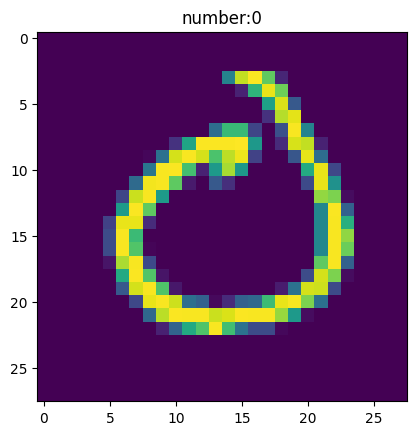

In [6]:
dic_ds = mnist_ds.create_dict_iterator() # Convert dataset to dictionary type
item = dic_ds.__next__()
img = item["image"].asnumpy()
label = item["label"].asnumpy()

print("The item of mnist_ds:", item.keys()) # Take a single data to view the data structure, including two keys, image and label
print("Tensor of image in item:", img.shape) # View the tensor of image (28,28,1)
print("The label of item:", label)

plt.imshow(np.squeeze(img))
plt.title("number:%s"% item["label"])
plt.show()


In [8]:
# Data processing module
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.vision import Inter
from mindspore.common import dtype as mstype


def create_dataset(data_path, batch_size=32, repeat_size=1,
                   num_parallel_workers=1):
    """ create dataset for train or test
    Args:
        data_path: Data path
        batch_size: The number of data records in each group
        repeat_size: The number of replicated data records
        num_parallel_workers: The number of parallel workers
    """
    # define dataset
    mnist_ds = ds.MnistDataset(data_path)

    # Define some parameters needed for data enhancement and rough justification
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    # According to the parameters, generate the corresponding data enhancement method
    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)  # Resize images to (32, 32) by bilinear interpolation
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml) # normalize images
    rescale_op = CV.Rescale(rescale, shift) # rescale images
    hwc2chw_op = CV.HWC2CHW() # change shape from (height, width, channel) to (channel, height, width) to fit network.
    type_cast_op = C.TypeCast(mstype.int32) # change data type of label to int32 to fit network

    # Using map () to apply operations to a dataset
    mnist_ds = mnist_ds.map(input_columns="label", operations=type_cast_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=resize_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=rescale_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=rescale_nml_op, num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(input_columns="image", operations=hwc2chw_op, num_parallel_workers=num_parallel_workers)
    # Process the generated dataset
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)  # 10000 as in LeNet train script
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    mnist_ds = mnist_ds.repeat(repeat_size)

    return mnist_ds


In [11]:
datas = create_dataset(train_data_path) # Process the train dataset
print('Number of groups in the dataset:', datas.get_dataset_size()) # Number of query dataset groups


[WARNING] ME(15604:13072,MainProcess):2023-06-02-19:15:35.643.146 [mindspore\dataset\core\validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(15604:13072,MainProcess):2023-06-02-19:15:35.644.143 [mindspore\dataset\core\validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(15604:13072,MainProcess):2023-06-02-19:15:35.645.139 [mindspore\dataset\core\validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(15604:13072,MainProcess):2023-06-02-19:15:35.646.135 [mindspore\dataset\core\validator_helpers.py:806] 'HWC

Number of groups in the dataset: 1875


In [ ]:
data = datas.create_dict_iterator().__next__() # Take a set of datasets
print(data.keys())
images = data["image"].asnumpy() # Take out the image data in this dataset
labels = data["label"].asnumpy() # Take out the label (subscript) of this data set
print('Tensor of image:', images.shape) # Query the tensor of images in each dataset (32,1,32,32)
print('labels:', labels)


In [ ]:
count = 1
for i in images:
    plt.subplot(4, 8, count) 
    plt.imshow(np.squeeze(i))
    plt.title('num:%s'%labels[count-1])
    plt.xticks([])
    count += 1
    plt.axis("off")
plt.show() # Print a total of 32 pictures in the group


In [ ]:
import mindspore.nn as nn
from mindspore.common.initializer import TruncatedNormal

In [ ]:
import mindspore.nn as nn
from mindspore.common.initializer import TruncatedNormal

# Initialize 2D convolution function
def conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    """Conv layer weight initial."""
    weight = weight_variable()
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight, has_bias=False, pad_mode="valid")

# Initialize full connection layer
def fc_with_initialize(input_channels, out_channels):
    """Fc layer weight initial."""
    weight = weight_variable()
    bias = weight_variable()
    return nn.Dense(input_channels, out_channels, weight, bias)

# Set truncated normal distribution
def weight_variable():
    """Weight initial."""
    return TruncatedNormal(0.02)


In [ ]:
class LeNet5(nn.Cell):
    """Lenet network structure."""
    # define the operator required
    def __init__(self):
        super(LeNet5, self).__init__()
        self.batch_size = 32 # 32 pictures in each group
        self.conv1 = conv(1, 6, 5) # Convolution layer 1, 1 channel input (1 Figure), 6 channel output (6 figures), convolution core 5 * 5
        self.conv2 = conv(6, 16, 5) # Convolution layer 2,6-channel input, 16 channel output, convolution kernel 5 * 5
        self.fc1 = fc_with_initialize(16 * 5 * 5, 120)
        self.fc2 = fc_with_initialize(120, 84)
        self.fc3 = fc_with_initialize(84, 10)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    # use the preceding operators to construct networks
    def construct(self, x):
        x = self.conv1(x) # 1*32*32-->6*28*28
        x = self.relu(x) # 6*28*28-->6*14*14
        x = self.max_pool2d(x) # Pool layer
        x = self.conv2(x) # Convolution layer
        x = self.relu(x) # Function excitation layer
        x = self.max_pool2d(x) # Pool layer
        x = self.flatten(x) # Dimensionality reduction
        x = self.fc1(x) # Full connection
        x = self.relu(x) # Function excitation layer
        x = self.fc2(x) # Full connection
        x = self.relu(x) # Function excitation layer
        x = self.fc3(x) # Full connection
        return x


In [ ]:
network = LeNet5()
print(network)


In [ ]:
param = network.trainable_params()
param


In [ ]:
# Training and testing related modules
import argparse
from mindspore import Tensor
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor,Callback
from mindspore.train import Model
from mindspore.nn.metrics import Accuracy
from mindspore.nn.loss import SoftmaxCrossEntropyWithLogits

def train_net(model, epoch_size, mnist_path, repeat_size, ckpoint_cb, step_loss_info):
    """Define the training method."""
    print("============== Starting Training ==============")
    # load training dataset
    ds_train = create_dataset(os.path.join(mnist_path, "train"), 32, repeat_size)
    model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, LossMonitor(), step_loss_info], dataset_sink_mode=True)

In [ ]:
# Custom callback function
class Step_loss_info(Callback):
    def step_end(self, run_context):
        cb_params = run_context.original_args()
        # step_ Loss dictionary for saving loss value and step number information
        step_loss["loss_value"].append(str(cb_params.net_outputs))
        step_loss["step"].append(str(cb_params.cur_step_num))

In [ ]:
import os

if os.name == "nt":
    os.system('del/f/s/q *.ckpt *.meta')# Clean up old run files before in Windows
else:
    os.system('rm -f *.ckpt *.meta *.pb')# Clean up old run files before in Linux

lr = 0.01 # learning rate
momentum = 0.9 #

# create the network
network = LeNet5()

# define the optimizer
net_opt = nn.Momentum(network.trainable_params(), lr, momentum)


# define the loss function
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

In [22]:
# define the model
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()} )


epoch_size = 10
mnist_path = "./MNIST_Data"

config_ck = CheckpointConfig(save_checkpoint_steps=125, keep_checkpoint_max=16)
# save the network model and parameters for subsequence fine-tuning

ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", config=config_ck)
# group layers into an object with training and evaluation features
step_loss = {"step": [], "loss_value": []}
# step_ Loss dictionary for saving loss value and step number information
step_loss_info = Step_loss_info()
# save the steps and loss value
repeat_size = 1
train_net(model, epoch_size, mnist_path, repeat_size, ckpoint_cb, step_loss_info)

[WARNING] ME(15604:13072,MainProcess):2023-06-02-19:15:40.213.555 [mindspore\dataset\core\validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(15604:13072,MainProcess):2023-06-02-19:15:40.214.556 [mindspore\dataset\core\validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(15604:13072,MainProcess):2023-06-02-19:15:40.215.552 [mindspore\dataset\core\validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(15604:13072,MainProcess):2023-06-02-19:15:40.216.187 [mindspore\dataset\core\validator_helpers.py:806] 'HWC

============== Starting Training ==============
epoch: 1 step: 1, loss is 2.3003487586975098
epoch: 1 step: 2, loss is 2.290452480316162
epoch: 1 step: 3, loss is 2.302185297012329
epoch: 1 step: 4, loss is 2.3046181201934814
epoch: 1 step: 5, loss is 2.3020522594451904
epoch: 1 step: 6, loss is 2.2919387817382812
epoch: 1 step: 7, loss is 2.3050315380096436
epoch: 1 step: 8, loss is 2.3036491870880127
epoch: 1 step: 9, loss is 2.307202100753784
epoch: 1 step: 10, loss is 2.3037939071655273
epoch: 1 step: 11, loss is 2.30085825920105
epoch: 1 step: 12, loss is 2.3018219470977783
epoch: 1 step: 13, loss is 2.3042964935302734
epoch: 1 step: 14, loss is 2.3053927421569824
epoch: 1 step: 15, loss is 2.3023974895477295
epoch: 1 step: 16, loss is 2.313068389892578
epoch: 1 step: 17, loss is 2.309704065322876
epoch: 1 step: 18, loss is 2.3036530017852783
epoch: 1 step: 19, loss is 2.3093321323394775
epoch: 1 step: 20, loss is 2.3059241771698
epoch: 1 step: 21, loss is 2.3092241287231445
epoch

epoch: 1 step: 178, loss is 2.293227434158325
epoch: 1 step: 179, loss is 2.2831759452819824
epoch: 1 step: 180, loss is 2.309358596801758
epoch: 1 step: 181, loss is 2.3009684085845947
epoch: 1 step: 182, loss is 2.2895491123199463
epoch: 1 step: 183, loss is 2.2946550846099854
epoch: 1 step: 184, loss is 2.302689790725708
epoch: 1 step: 185, loss is 2.280441999435425
epoch: 1 step: 186, loss is 2.311687707901001
epoch: 1 step: 187, loss is 2.31898832321167
epoch: 1 step: 188, loss is 2.3073785305023193
epoch: 1 step: 189, loss is 2.318356513977051
epoch: 1 step: 190, loss is 2.3153786659240723
epoch: 1 step: 191, loss is 2.3047194480895996
epoch: 1 step: 192, loss is 2.3186240196228027
epoch: 1 step: 193, loss is 2.310842990875244
epoch: 1 step: 194, loss is 2.3054590225219727
epoch: 1 step: 195, loss is 2.299099922180176
epoch: 1 step: 196, loss is 2.3205535411834717
epoch: 1 step: 197, loss is 2.2927966117858887
epoch: 1 step: 198, loss is 2.320255756378174
epoch: 1 step: 199, loss

epoch: 1 step: 354, loss is 2.3016042709350586
epoch: 1 step: 355, loss is 2.3022098541259766
epoch: 1 step: 356, loss is 2.298671245574951
epoch: 1 step: 357, loss is 2.2975761890411377
epoch: 1 step: 358, loss is 2.2934134006500244
epoch: 1 step: 359, loss is 2.3183341026306152
epoch: 1 step: 360, loss is 2.2967898845672607
epoch: 1 step: 361, loss is 2.287968397140503
epoch: 1 step: 362, loss is 2.2985105514526367
epoch: 1 step: 363, loss is 2.300441265106201
epoch: 1 step: 364, loss is 2.2997593879699707
epoch: 1 step: 365, loss is 2.309478998184204
epoch: 1 step: 366, loss is 2.3163039684295654
epoch: 1 step: 367, loss is 2.2997424602508545
epoch: 1 step: 368, loss is 2.2921109199523926
epoch: 1 step: 369, loss is 2.29447078704834
epoch: 1 step: 370, loss is 2.291069746017456
epoch: 1 step: 371, loss is 2.2904562950134277
epoch: 1 step: 372, loss is 2.2894818782806396
epoch: 1 step: 373, loss is 2.3039493560791016
epoch: 1 step: 374, loss is 2.3058745861053467
epoch: 1 step: 375, 

epoch: 1 step: 531, loss is 2.302962303161621
epoch: 1 step: 532, loss is 2.3032584190368652
epoch: 1 step: 533, loss is 2.2971620559692383
epoch: 1 step: 534, loss is 2.291928768157959
epoch: 1 step: 535, loss is 2.3004233837127686
epoch: 1 step: 536, loss is 2.2898075580596924
epoch: 1 step: 537, loss is 2.305870532989502
epoch: 1 step: 538, loss is 2.3005318641662598
epoch: 1 step: 539, loss is 2.308342456817627
epoch: 1 step: 540, loss is 2.2931206226348877
epoch: 1 step: 541, loss is 2.307864189147949
epoch: 1 step: 542, loss is 2.2912685871124268
epoch: 1 step: 543, loss is 2.3220086097717285
epoch: 1 step: 544, loss is 2.2858426570892334
epoch: 1 step: 545, loss is 2.3006317615509033
epoch: 1 step: 546, loss is 2.2889277935028076
epoch: 1 step: 547, loss is 2.2942075729370117
epoch: 1 step: 548, loss is 2.3047914505004883
epoch: 1 step: 549, loss is 2.2920186519622803
epoch: 1 step: 550, loss is 2.297638177871704
epoch: 1 step: 551, loss is 2.3059346675872803
epoch: 1 step: 552,

epoch: 1 step: 708, loss is 2.291566848754883
epoch: 1 step: 709, loss is 2.304319381713867
epoch: 1 step: 710, loss is 2.296205520629883
epoch: 1 step: 711, loss is 2.304431200027466
epoch: 1 step: 712, loss is 2.3052165508270264
epoch: 1 step: 713, loss is 2.2953901290893555
epoch: 1 step: 714, loss is 2.3068766593933105
epoch: 1 step: 715, loss is 2.304093837738037
epoch: 1 step: 716, loss is 2.300747871398926
epoch: 1 step: 717, loss is 2.314241886138916
epoch: 1 step: 718, loss is 2.2961273193359375
epoch: 1 step: 719, loss is 2.2999303340911865
epoch: 1 step: 720, loss is 2.3066020011901855
epoch: 1 step: 721, loss is 2.308279514312744
epoch: 1 step: 722, loss is 2.2885804176330566
epoch: 1 step: 723, loss is 2.305025100708008
epoch: 1 step: 724, loss is 2.2911009788513184
epoch: 1 step: 725, loss is 2.293337345123291
epoch: 1 step: 726, loss is 2.3032853603363037
epoch: 1 step: 727, loss is 2.2957937717437744
epoch: 1 step: 728, loss is 2.3129215240478516
epoch: 1 step: 729, los

epoch: 1 step: 885, loss is 2.2973873615264893
epoch: 1 step: 886, loss is 2.287482976913452
epoch: 1 step: 887, loss is 2.312176465988159
epoch: 1 step: 888, loss is 2.2914323806762695
epoch: 1 step: 889, loss is 2.295954465866089
epoch: 1 step: 890, loss is 2.3087596893310547
epoch: 1 step: 891, loss is 2.2998640537261963
epoch: 1 step: 892, loss is 2.300652027130127
epoch: 1 step: 893, loss is 2.2922441959381104
epoch: 1 step: 894, loss is 2.310140609741211
epoch: 1 step: 895, loss is 2.3014299869537354
epoch: 1 step: 896, loss is 2.3048906326293945
epoch: 1 step: 897, loss is 2.308513641357422
epoch: 1 step: 898, loss is 2.2685461044311523
epoch: 1 step: 899, loss is 2.294870615005493
epoch: 1 step: 900, loss is 2.2717981338500977
epoch: 1 step: 901, loss is 2.2866530418395996
epoch: 1 step: 902, loss is 2.294490337371826
epoch: 1 step: 903, loss is 2.3010525703430176
epoch: 1 step: 904, loss is 2.2857165336608887
epoch: 1 step: 905, loss is 2.2839245796203613
epoch: 1 step: 906, l

epoch: 1 step: 1061, loss is 2.285492181777954
epoch: 1 step: 1062, loss is 2.2772583961486816
epoch: 1 step: 1063, loss is 2.2928802967071533
epoch: 1 step: 1064, loss is 2.2690162658691406
epoch: 1 step: 1065, loss is 2.275785446166992
epoch: 1 step: 1066, loss is 2.2747344970703125
epoch: 1 step: 1067, loss is 2.2600321769714355
epoch: 1 step: 1068, loss is 2.285566806793213
epoch: 1 step: 1069, loss is 2.255173444747925
epoch: 1 step: 1070, loss is 2.2788524627685547
epoch: 1 step: 1071, loss is 2.260751962661743
epoch: 1 step: 1072, loss is 2.2694194316864014
epoch: 1 step: 1073, loss is 2.261918306350708
epoch: 1 step: 1074, loss is 2.26137375831604
epoch: 1 step: 1075, loss is 2.267711639404297
epoch: 1 step: 1076, loss is 2.226271867752075
epoch: 1 step: 1077, loss is 2.2558915615081787
epoch: 1 step: 1078, loss is 2.2561843395233154
epoch: 1 step: 1079, loss is 2.224090814590454
epoch: 1 step: 1080, loss is 2.2335572242736816
epoch: 1 step: 1081, loss is 2.232692241668701
epoc

epoch: 1 step: 1233, loss is 0.6528486609458923
epoch: 1 step: 1234, loss is 0.43434077501296997
epoch: 1 step: 1235, loss is 0.671442985534668
epoch: 1 step: 1236, loss is 0.4022964537143707
epoch: 1 step: 1237, loss is 0.29868635535240173
epoch: 1 step: 1238, loss is 0.2871129512786865
epoch: 1 step: 1239, loss is 0.32641932368278503
epoch: 1 step: 1240, loss is 0.2772595286369324
epoch: 1 step: 1241, loss is 0.476924866437912
epoch: 1 step: 1242, loss is 0.211623415350914
epoch: 1 step: 1243, loss is 0.7279724478721619
epoch: 1 step: 1244, loss is 0.27171021699905396
epoch: 1 step: 1245, loss is 0.760542631149292
epoch: 1 step: 1246, loss is 0.2652062475681305
epoch: 1 step: 1247, loss is 0.8356221914291382
epoch: 1 step: 1248, loss is 0.16872480511665344
epoch: 1 step: 1249, loss is 0.4120922088623047
epoch: 1 step: 1250, loss is 0.21625973284244537
epoch: 1 step: 1251, loss is 0.21807588636875153
epoch: 1 step: 1252, loss is 0.3030988574028015
epoch: 1 step: 1253, loss is 0.332996

epoch: 1 step: 1403, loss is 0.16834965348243713
epoch: 1 step: 1404, loss is 0.3070136606693268
epoch: 1 step: 1405, loss is 0.2969735562801361
epoch: 1 step: 1406, loss is 0.3384643793106079
epoch: 1 step: 1407, loss is 0.11425626277923584
epoch: 1 step: 1408, loss is 0.196400448679924
epoch: 1 step: 1409, loss is 0.08856234699487686
epoch: 1 step: 1410, loss is 0.12501047551631927
epoch: 1 step: 1411, loss is 0.164876788854599
epoch: 1 step: 1412, loss is 0.17107968032360077
epoch: 1 step: 1413, loss is 0.22010537981987
epoch: 1 step: 1414, loss is 0.46276402473449707
epoch: 1 step: 1415, loss is 0.43027836084365845
epoch: 1 step: 1416, loss is 0.42547163367271423
epoch: 1 step: 1417, loss is 0.27498388290405273
epoch: 1 step: 1418, loss is 0.2856829762458801
epoch: 1 step: 1419, loss is 0.060898225754499435
epoch: 1 step: 1420, loss is 0.5560422539710999
epoch: 1 step: 1421, loss is 0.21752509474754333
epoch: 1 step: 1422, loss is 0.2478926181793213
epoch: 1 step: 1423, loss is 0.1

epoch: 1 step: 1572, loss is 0.028620189055800438
epoch: 1 step: 1573, loss is 0.11335963010787964
epoch: 1 step: 1574, loss is 0.04047133028507233
epoch: 1 step: 1575, loss is 0.06826715916395187
epoch: 1 step: 1576, loss is 0.06811244040727615
epoch: 1 step: 1577, loss is 0.4699014127254486
epoch: 1 step: 1578, loss is 0.054742250591516495
epoch: 1 step: 1579, loss is 0.017278922721743584
epoch: 1 step: 1580, loss is 0.25631579756736755
epoch: 1 step: 1581, loss is 0.0387328676879406
epoch: 1 step: 1582, loss is 0.18620191514492035
epoch: 1 step: 1583, loss is 0.026882587000727654
epoch: 1 step: 1584, loss is 0.021693237125873566
epoch: 1 step: 1585, loss is 0.18536056578159332
epoch: 1 step: 1586, loss is 0.02796868421137333
epoch: 1 step: 1587, loss is 0.013030203990638256
epoch: 1 step: 1588, loss is 0.01382145844399929
epoch: 1 step: 1589, loss is 0.06778298318386078
epoch: 1 step: 1590, loss is 0.009744333103299141
epoch: 1 step: 1591, loss is 0.07657015323638916
epoch: 1 step: 

epoch: 1 step: 1740, loss is 0.027233684435486794
epoch: 1 step: 1741, loss is 0.05598892644047737
epoch: 1 step: 1742, loss is 0.10664793103933334
epoch: 1 step: 1743, loss is 0.10292337089776993
epoch: 1 step: 1744, loss is 0.21761742234230042
epoch: 1 step: 1745, loss is 0.17414402961730957
epoch: 1 step: 1746, loss is 0.15943463146686554
epoch: 1 step: 1747, loss is 0.14017193019390106
epoch: 1 step: 1748, loss is 0.039394207298755646
epoch: 1 step: 1749, loss is 0.13848736882209778
epoch: 1 step: 1750, loss is 0.10443749278783798
epoch: 1 step: 1751, loss is 0.16852238774299622
epoch: 1 step: 1752, loss is 0.161595419049263
epoch: 1 step: 1753, loss is 0.054970186203718185
epoch: 1 step: 1754, loss is 0.12614603340625763
epoch: 1 step: 1755, loss is 0.31639429926872253
epoch: 1 step: 1756, loss is 0.06354096531867981
epoch: 1 step: 1757, loss is 0.022911978885531425
epoch: 1 step: 1758, loss is 0.3684399724006653
epoch: 1 step: 1759, loss is 0.13949553668498993
epoch: 1 step: 1760

epoch: 2 step: 34, loss is 0.05976823344826698
epoch: 2 step: 35, loss is 0.12994883954524994
epoch: 2 step: 36, loss is 0.042095739394426346
epoch: 2 step: 37, loss is 0.06396344304084778
epoch: 2 step: 38, loss is 0.07395017892122269
epoch: 2 step: 39, loss is 0.1667698174715042
epoch: 2 step: 40, loss is 0.01727966219186783
epoch: 2 step: 41, loss is 0.010975854471325874
epoch: 2 step: 42, loss is 0.10047256201505661
epoch: 2 step: 43, loss is 0.004411973524838686
epoch: 2 step: 44, loss is 0.3514058291912079
epoch: 2 step: 45, loss is 0.029206253588199615
epoch: 2 step: 46, loss is 0.03923307731747627
epoch: 2 step: 47, loss is 0.06134243309497833
epoch: 2 step: 48, loss is 0.07811342179775238
epoch: 2 step: 49, loss is 0.0034883262123912573
epoch: 2 step: 50, loss is 0.03365014120936394
epoch: 2 step: 51, loss is 0.02860383875668049
epoch: 2 step: 52, loss is 0.10969986021518707
epoch: 2 step: 53, loss is 0.012227118946611881
epoch: 2 step: 54, loss is 0.03425151854753494
epoch: 2

epoch: 2 step: 206, loss is 0.21788503229618073
epoch: 2 step: 207, loss is 0.16311004757881165
epoch: 2 step: 208, loss is 0.05212005227804184
epoch: 2 step: 209, loss is 0.304904967546463
epoch: 2 step: 210, loss is 0.029729463160037994
epoch: 2 step: 211, loss is 0.07567722350358963
epoch: 2 step: 212, loss is 0.04605840891599655
epoch: 2 step: 213, loss is 0.21708668768405914
epoch: 2 step: 214, loss is 0.0901225209236145
epoch: 2 step: 215, loss is 0.05898749455809593
epoch: 2 step: 216, loss is 0.11935270577669144
epoch: 2 step: 217, loss is 0.025069113820791245
epoch: 2 step: 218, loss is 0.15348820388317108
epoch: 2 step: 219, loss is 0.08632377535104752
epoch: 2 step: 220, loss is 0.0394974984228611
epoch: 2 step: 221, loss is 0.0976523905992508
epoch: 2 step: 222, loss is 0.11417252570390701
epoch: 2 step: 223, loss is 0.02688358910381794
epoch: 2 step: 224, loss is 0.05042032152414322
epoch: 2 step: 225, loss is 0.1804041862487793
epoch: 2 step: 226, loss is 0.06084737181663

epoch: 2 step: 377, loss is 0.12900309264659882
epoch: 2 step: 378, loss is 0.029634416103363037
epoch: 2 step: 379, loss is 0.02136235311627388
epoch: 2 step: 380, loss is 0.003389328718185425
epoch: 2 step: 381, loss is 0.3583771884441376
epoch: 2 step: 382, loss is 0.10509109497070312
epoch: 2 step: 383, loss is 0.0429922379553318
epoch: 2 step: 384, loss is 0.08663392066955566
epoch: 2 step: 385, loss is 0.041700929403305054
epoch: 2 step: 386, loss is 0.1214863583445549
epoch: 2 step: 387, loss is 0.22445927560329437
epoch: 2 step: 388, loss is 0.004747671075165272
epoch: 2 step: 389, loss is 0.020346423611044884
epoch: 2 step: 390, loss is 0.08340708166360855
epoch: 2 step: 391, loss is 0.17042122781276703
epoch: 2 step: 392, loss is 0.0222789216786623
epoch: 2 step: 393, loss is 0.09055766463279724
epoch: 2 step: 394, loss is 0.0019446740625426173
epoch: 2 step: 395, loss is 0.016319291666150093
epoch: 2 step: 396, loss is 0.06202937290072441
epoch: 2 step: 397, loss is 0.269998

epoch: 2 step: 547, loss is 0.08955302834510803
epoch: 2 step: 548, loss is 0.010135838761925697
epoch: 2 step: 549, loss is 0.10202246904373169
epoch: 2 step: 550, loss is 0.0738346204161644
epoch: 2 step: 551, loss is 0.35629937052726746
epoch: 2 step: 552, loss is 0.08139225840568542
epoch: 2 step: 553, loss is 0.0915411114692688
epoch: 2 step: 554, loss is 0.1931271106004715
epoch: 2 step: 555, loss is 0.25870537757873535
epoch: 2 step: 556, loss is 0.04837726801633835
epoch: 2 step: 557, loss is 0.06686127930879593
epoch: 2 step: 558, loss is 0.018350880593061447
epoch: 2 step: 559, loss is 0.013519372791051865
epoch: 2 step: 560, loss is 0.04731248319149017
epoch: 2 step: 561, loss is 0.09294187277555466
epoch: 2 step: 562, loss is 0.42191633582115173
epoch: 2 step: 563, loss is 0.18027417361736298
epoch: 2 step: 564, loss is 0.021092383190989494
epoch: 2 step: 565, loss is 0.16120290756225586
epoch: 2 step: 566, loss is 0.08449762314558029
epoch: 2 step: 567, loss is 0.011998795

epoch: 2 step: 718, loss is 0.004840596113353968
epoch: 2 step: 719, loss is 0.2096341848373413
epoch: 2 step: 720, loss is 0.012931177392601967
epoch: 2 step: 721, loss is 0.03546064347028732
epoch: 2 step: 722, loss is 0.0016481985803693533
epoch: 2 step: 723, loss is 0.29191598296165466
epoch: 2 step: 724, loss is 0.08229750394821167
epoch: 2 step: 725, loss is 0.05881073698401451
epoch: 2 step: 726, loss is 0.14628145098686218
epoch: 2 step: 727, loss is 0.02201673947274685
epoch: 2 step: 728, loss is 0.18065939843654633
epoch: 2 step: 729, loss is 0.044192709028720856
epoch: 2 step: 730, loss is 0.11907434463500977
epoch: 2 step: 731, loss is 0.03736703842878342
epoch: 2 step: 732, loss is 0.07366859912872314
epoch: 2 step: 733, loss is 0.008488984778523445
epoch: 2 step: 734, loss is 0.11248522251844406
epoch: 2 step: 735, loss is 0.010820786468684673
epoch: 2 step: 736, loss is 0.0419435016810894
epoch: 2 step: 737, loss is 0.0046731834299862385
epoch: 2 step: 738, loss is 0.144

epoch: 2 step: 888, loss is 0.001876220921985805
epoch: 2 step: 889, loss is 0.2368759959936142
epoch: 2 step: 890, loss is 0.029957303777337074
epoch: 2 step: 891, loss is 0.06211409717798233
epoch: 2 step: 892, loss is 0.04788995534181595
epoch: 2 step: 893, loss is 0.024384280666708946
epoch: 2 step: 894, loss is 0.01617944799363613
epoch: 2 step: 895, loss is 0.0022446310613304377
epoch: 2 step: 896, loss is 0.03722401708364487
epoch: 2 step: 897, loss is 0.05889400839805603
epoch: 2 step: 898, loss is 0.33900266885757446
epoch: 2 step: 899, loss is 0.007505682297050953
epoch: 2 step: 900, loss is 0.01585114561021328
epoch: 2 step: 901, loss is 0.004554229788482189
epoch: 2 step: 902, loss is 0.005087094381451607
epoch: 2 step: 903, loss is 0.023943061009049416
epoch: 2 step: 904, loss is 0.23371559381484985
epoch: 2 step: 905, loss is 0.03636869788169861
epoch: 2 step: 906, loss is 0.021334286779165268
epoch: 2 step: 907, loss is 0.15292973816394806
epoch: 2 step: 908, loss is 0.0

epoch: 2 step: 1057, loss is 0.09453054517507553
epoch: 2 step: 1058, loss is 0.03336300328373909
epoch: 2 step: 1059, loss is 0.0747152641415596
epoch: 2 step: 1060, loss is 0.4572548568248749
epoch: 2 step: 1061, loss is 0.06824425607919693
epoch: 2 step: 1062, loss is 0.026360362768173218
epoch: 2 step: 1063, loss is 0.05106913670897484
epoch: 2 step: 1064, loss is 0.01670732907950878
epoch: 2 step: 1065, loss is 0.02957598678767681
epoch: 2 step: 1066, loss is 0.050829529762268066
epoch: 2 step: 1067, loss is 0.06265132874250412
epoch: 2 step: 1068, loss is 0.015490812249481678
epoch: 2 step: 1069, loss is 0.057416267693042755
epoch: 2 step: 1070, loss is 0.05104035511612892
epoch: 2 step: 1071, loss is 0.06300531327724457
epoch: 2 step: 1072, loss is 0.03201613575220108
epoch: 2 step: 1073, loss is 0.022769061848521233
epoch: 2 step: 1074, loss is 0.14753110706806183
epoch: 2 step: 1075, loss is 0.10923277586698532
epoch: 2 step: 1076, loss is 0.01872766576707363
epoch: 2 step: 10

epoch: 2 step: 1224, loss is 0.007985036820173264
epoch: 2 step: 1225, loss is 0.14100146293640137
epoch: 2 step: 1226, loss is 0.1307525932788849
epoch: 2 step: 1227, loss is 0.2446032613515854
epoch: 2 step: 1228, loss is 0.01641307771205902
epoch: 2 step: 1229, loss is 0.10535530000925064
epoch: 2 step: 1230, loss is 0.05393057316541672
epoch: 2 step: 1231, loss is 0.04035932198166847
epoch: 2 step: 1232, loss is 0.15281923115253448
epoch: 2 step: 1233, loss is 0.02055741287767887
epoch: 2 step: 1234, loss is 0.15283088386058807
epoch: 2 step: 1235, loss is 0.004679478704929352
epoch: 2 step: 1236, loss is 0.013644294813275337
epoch: 2 step: 1237, loss is 0.2065839320421219
epoch: 2 step: 1238, loss is 0.040374740958213806
epoch: 2 step: 1239, loss is 0.033328041434288025
epoch: 2 step: 1240, loss is 0.08611977100372314
epoch: 2 step: 1241, loss is 0.03903932496905327
epoch: 2 step: 1242, loss is 0.08192469924688339
epoch: 2 step: 1243, loss is 0.005587873049080372
epoch: 2 step: 12

epoch: 2 step: 1391, loss is 0.02429046481847763
epoch: 2 step: 1392, loss is 0.09285969287157059
epoch: 2 step: 1393, loss is 0.12569549679756165
epoch: 2 step: 1394, loss is 0.02329159900546074
epoch: 2 step: 1395, loss is 0.03239411115646362
epoch: 2 step: 1396, loss is 0.13658714294433594
epoch: 2 step: 1397, loss is 0.25627562403678894
epoch: 2 step: 1398, loss is 0.003992569167166948
epoch: 2 step: 1399, loss is 0.021011747419834137
epoch: 2 step: 1400, loss is 0.040371377021074295
epoch: 2 step: 1401, loss is 0.015484564006328583
epoch: 2 step: 1402, loss is 0.1370585709810257
epoch: 2 step: 1403, loss is 0.2257220596075058
epoch: 2 step: 1404, loss is 0.12070724368095398
epoch: 2 step: 1405, loss is 0.0056209503673017025
epoch: 2 step: 1406, loss is 0.061457403004169464
epoch: 2 step: 1407, loss is 0.23974403738975525
epoch: 2 step: 1408, loss is 0.1294303685426712
epoch: 2 step: 1409, loss is 0.1379520446062088
epoch: 2 step: 1410, loss is 0.016550391912460327
epoch: 2 step: 1

epoch: 2 step: 1558, loss is 0.12062034010887146
epoch: 2 step: 1559, loss is 0.007049111649394035
epoch: 2 step: 1560, loss is 0.005630567669868469
epoch: 2 step: 1561, loss is 0.10317407548427582
epoch: 2 step: 1562, loss is 0.034628935158252716
epoch: 2 step: 1563, loss is 0.04208095371723175
epoch: 2 step: 1564, loss is 0.1315487027168274
epoch: 2 step: 1565, loss is 0.05681318789720535
epoch: 2 step: 1566, loss is 0.02816067263484001
epoch: 2 step: 1567, loss is 0.02045663632452488
epoch: 2 step: 1568, loss is 0.002819869900122285
epoch: 2 step: 1569, loss is 0.01915883645415306
epoch: 2 step: 1570, loss is 0.03584790229797363
epoch: 2 step: 1571, loss is 0.16702690720558167
epoch: 2 step: 1572, loss is 0.1455332189798355
epoch: 2 step: 1573, loss is 0.08014070242643356
epoch: 2 step: 1574, loss is 0.05818450078368187
epoch: 2 step: 1575, loss is 0.016207728534936905
epoch: 2 step: 1576, loss is 0.10976430028676987
epoch: 2 step: 1577, loss is 0.010233614593744278
epoch: 2 step: 1

epoch: 2 step: 1724, loss is 0.038743313401937485
epoch: 2 step: 1725, loss is 0.03816317394375801
epoch: 2 step: 1726, loss is 0.0860442966222763
epoch: 2 step: 1727, loss is 0.11296427994966507
epoch: 2 step: 1728, loss is 0.005649796221405268
epoch: 2 step: 1729, loss is 0.006399298552423716
epoch: 2 step: 1730, loss is 0.0054839421063661575
epoch: 2 step: 1731, loss is 0.026632923632860184
epoch: 2 step: 1732, loss is 0.10421785712242126
epoch: 2 step: 1733, loss is 0.047595538198947906
epoch: 2 step: 1734, loss is 0.00811278261244297
epoch: 2 step: 1735, loss is 0.024281244724988937
epoch: 2 step: 1736, loss is 0.0008875280618667603
epoch: 2 step: 1737, loss is 0.015875935554504395
epoch: 2 step: 1738, loss is 0.037762053310871124
epoch: 2 step: 1739, loss is 0.08297013491392136
epoch: 2 step: 1740, loss is 0.032573189586400986
epoch: 2 step: 1741, loss is 0.22966381907463074
epoch: 2 step: 1742, loss is 0.024701200425624847
epoch: 2 step: 1743, loss is 0.19444631040096283
epoch: 

epoch: 3 step: 16, loss is 0.008904987946152687
epoch: 3 step: 17, loss is 0.20084117352962494
epoch: 3 step: 18, loss is 0.0703972801566124
epoch: 3 step: 19, loss is 0.023613939061760902
epoch: 3 step: 20, loss is 0.009736377745866776
epoch: 3 step: 21, loss is 0.012269101105630398
epoch: 3 step: 22, loss is 0.05652427300810814
epoch: 3 step: 23, loss is 0.010658868588507175
epoch: 3 step: 24, loss is 0.04868178814649582
epoch: 3 step: 25, loss is 0.299113929271698
epoch: 3 step: 26, loss is 0.02045808546245098
epoch: 3 step: 27, loss is 0.18632365763187408
epoch: 3 step: 28, loss is 0.012018066830933094
epoch: 3 step: 29, loss is 0.009944603778421879
epoch: 3 step: 30, loss is 0.16987136006355286
epoch: 3 step: 31, loss is 0.041755951941013336
epoch: 3 step: 32, loss is 0.007938344031572342
epoch: 3 step: 33, loss is 0.007771275471895933
epoch: 3 step: 34, loss is 0.013964819721877575
epoch: 3 step: 35, loss is 0.006664827931672335
epoch: 3 step: 36, loss is 0.011564277112483978
epo

epoch: 3 step: 187, loss is 0.0593191534280777
epoch: 3 step: 188, loss is 0.010105395689606667
epoch: 3 step: 189, loss is 0.036223191767930984
epoch: 3 step: 190, loss is 0.11464429646730423
epoch: 3 step: 191, loss is 0.006010795012116432
epoch: 3 step: 192, loss is 0.008855925872921944
epoch: 3 step: 193, loss is 0.00866687297821045
epoch: 3 step: 194, loss is 0.0034404562320560217
epoch: 3 step: 195, loss is 0.022849809378385544
epoch: 3 step: 196, loss is 0.0008766853134147823
epoch: 3 step: 197, loss is 0.009483834728598595
epoch: 3 step: 198, loss is 0.15887793898582458
epoch: 3 step: 199, loss is 0.0543137788772583
epoch: 3 step: 200, loss is 0.0072625079192221165
epoch: 3 step: 201, loss is 0.002864337060600519
epoch: 3 step: 202, loss is 0.05831833928823471
epoch: 3 step: 203, loss is 0.001093456638045609
epoch: 3 step: 204, loss is 0.0024385093711316586
epoch: 3 step: 205, loss is 0.0009007089538499713
epoch: 3 step: 206, loss is 0.003421127563342452
epoch: 3 step: 207, los

epoch: 3 step: 356, loss is 0.08719835430383682
epoch: 3 step: 357, loss is 0.003888990031555295
epoch: 3 step: 358, loss is 0.0009092214168049395
epoch: 3 step: 359, loss is 0.02265855111181736
epoch: 3 step: 360, loss is 0.01238956954330206
epoch: 3 step: 361, loss is 0.023229407146573067
epoch: 3 step: 362, loss is 0.01119456347078085
epoch: 3 step: 363, loss is 0.07198729366064072
epoch: 3 step: 364, loss is 0.013415966182947159
epoch: 3 step: 365, loss is 0.017721647396683693
epoch: 3 step: 366, loss is 0.10017717629671097
epoch: 3 step: 367, loss is 0.03930380567908287
epoch: 3 step: 368, loss is 0.1350565105676651
epoch: 3 step: 369, loss is 0.09167785942554474
epoch: 3 step: 370, loss is 0.011778945103287697
epoch: 3 step: 371, loss is 0.01948527805507183
epoch: 3 step: 372, loss is 0.28171899914741516
epoch: 3 step: 373, loss is 0.004246617667376995
epoch: 3 step: 374, loss is 0.035837750881910324
epoch: 3 step: 375, loss is 0.019772784784436226
epoch: 3 step: 376, loss is 0.0

epoch: 3 step: 525, loss is 0.0011522475397214293
epoch: 3 step: 526, loss is 0.018132084980607033
epoch: 3 step: 527, loss is 0.02293003350496292
epoch: 3 step: 528, loss is 0.009992138482630253
epoch: 3 step: 529, loss is 0.0738181471824646
epoch: 3 step: 530, loss is 0.025641130283474922
epoch: 3 step: 531, loss is 0.07333719730377197
epoch: 3 step: 532, loss is 0.07590556889772415
epoch: 3 step: 533, loss is 0.10494723170995712
epoch: 3 step: 534, loss is 0.018519550561904907
epoch: 3 step: 535, loss is 0.10347054898738861
epoch: 3 step: 536, loss is 0.005554915871471167
epoch: 3 step: 537, loss is 0.05729171633720398
epoch: 3 step: 538, loss is 0.021637465804815292
epoch: 3 step: 539, loss is 0.0008996253018267453
epoch: 3 step: 540, loss is 0.004727370571345091
epoch: 3 step: 541, loss is 0.11981534957885742
epoch: 3 step: 542, loss is 0.0008457758813165128
epoch: 3 step: 543, loss is 0.05920987203717232
epoch: 3 step: 544, loss is 0.02306975983083248
epoch: 3 step: 545, loss is 

epoch: 3 step: 694, loss is 0.002050956478342414
epoch: 3 step: 695, loss is 0.12108449637889862
epoch: 3 step: 696, loss is 0.03251552954316139
epoch: 3 step: 697, loss is 0.11784782260656357
epoch: 3 step: 698, loss is 0.004368404857814312
epoch: 3 step: 699, loss is 0.35002002120018005
epoch: 3 step: 700, loss is 0.012749060057103634
epoch: 3 step: 701, loss is 0.2392352670431137
epoch: 3 step: 702, loss is 0.004950101487338543
epoch: 3 step: 703, loss is 0.09969451278448105
epoch: 3 step: 704, loss is 0.002791594248265028
epoch: 3 step: 705, loss is 0.019230270758271217
epoch: 3 step: 706, loss is 0.011963766999542713
epoch: 3 step: 707, loss is 0.009889857843518257
epoch: 3 step: 708, loss is 0.017394371330738068
epoch: 3 step: 709, loss is 0.030909067019820213
epoch: 3 step: 710, loss is 0.32991668581962585
epoch: 3 step: 711, loss is 0.12192342430353165
epoch: 3 step: 712, loss is 0.03669475018978119
epoch: 3 step: 713, loss is 0.032548580318689346
epoch: 3 step: 714, loss is 0.

epoch: 3 step: 863, loss is 0.012169083580374718
epoch: 3 step: 864, loss is 0.027065757662057877
epoch: 3 step: 865, loss is 0.004736743867397308
epoch: 3 step: 866, loss is 0.008374649100005627
epoch: 3 step: 867, loss is 0.028478382155299187
epoch: 3 step: 868, loss is 0.024729225784540176
epoch: 3 step: 869, loss is 0.019141197204589844
epoch: 3 step: 870, loss is 0.09439858049154282
epoch: 3 step: 871, loss is 0.018855493515729904
epoch: 3 step: 872, loss is 0.014216831885278225
epoch: 3 step: 873, loss is 0.03111816570162773
epoch: 3 step: 874, loss is 0.013531232252717018
epoch: 3 step: 875, loss is 0.005609484389424324
epoch: 3 step: 876, loss is 0.004999857861548662
epoch: 3 step: 877, loss is 0.014747096225619316
epoch: 3 step: 878, loss is 0.05069372057914734
epoch: 3 step: 879, loss is 0.09593917429447174
epoch: 3 step: 880, loss is 0.03307744860649109
epoch: 3 step: 881, loss is 0.019503796473145485
epoch: 3 step: 882, loss is 0.03213246911764145
epoch: 3 step: 883, loss i

epoch: 3 step: 1031, loss is 0.023113377392292023
epoch: 3 step: 1032, loss is 0.004892958793789148
epoch: 3 step: 1033, loss is 0.03307705000042915
epoch: 3 step: 1034, loss is 0.015418396331369877
epoch: 3 step: 1035, loss is 0.053294554352760315
epoch: 3 step: 1036, loss is 0.0030667977407574654
epoch: 3 step: 1037, loss is 0.029897183179855347
epoch: 3 step: 1038, loss is 0.03559374436736107
epoch: 3 step: 1039, loss is 0.0016729396302253008
epoch: 3 step: 1040, loss is 0.008713174611330032
epoch: 3 step: 1041, loss is 0.14519087970256805
epoch: 3 step: 1042, loss is 0.012705262750387192
epoch: 3 step: 1043, loss is 0.03273238614201546
epoch: 3 step: 1044, loss is 0.012530092149972916
epoch: 3 step: 1045, loss is 0.07295408099889755
epoch: 3 step: 1046, loss is 0.017365431413054466
epoch: 3 step: 1047, loss is 0.03617807850241661
epoch: 3 step: 1048, loss is 0.006026587449014187
epoch: 3 step: 1049, loss is 0.016833478584885597
epoch: 3 step: 1050, loss is 0.002954930765554309
epoc

epoch: 3 step: 1197, loss is 0.0729764923453331
epoch: 3 step: 1198, loss is 0.01582738384604454
epoch: 3 step: 1199, loss is 0.02404762990772724
epoch: 3 step: 1200, loss is 0.04056992754340172
epoch: 3 step: 1201, loss is 0.014479330740869045
epoch: 3 step: 1202, loss is 0.030480243265628815
epoch: 3 step: 1203, loss is 0.05877063795924187
epoch: 3 step: 1204, loss is 0.022941485047340393
epoch: 3 step: 1205, loss is 0.0032377876341342926
epoch: 3 step: 1206, loss is 0.19588930904865265
epoch: 3 step: 1207, loss is 0.11713964492082596
epoch: 3 step: 1208, loss is 0.00784203503280878
epoch: 3 step: 1209, loss is 0.011575596407055855
epoch: 3 step: 1210, loss is 0.009985392913222313
epoch: 3 step: 1211, loss is 0.0920400321483612
epoch: 3 step: 1212, loss is 0.07684590667486191
epoch: 3 step: 1213, loss is 0.1966320276260376
epoch: 3 step: 1214, loss is 0.10343854874372482
epoch: 3 step: 1215, loss is 0.007185620721429586
epoch: 3 step: 1216, loss is 0.12004410475492477
epoch: 3 step: 

epoch: 3 step: 1363, loss is 0.0345168374478817
epoch: 3 step: 1364, loss is 0.015400988981127739
epoch: 3 step: 1365, loss is 0.039238207042217255
epoch: 3 step: 1366, loss is 0.015817338600754738
epoch: 3 step: 1367, loss is 0.042094796895980835
epoch: 3 step: 1368, loss is 0.0039023403078317642
epoch: 3 step: 1369, loss is 0.007192249875515699
epoch: 3 step: 1370, loss is 0.17948345839977264
epoch: 3 step: 1371, loss is 0.001689885277301073
epoch: 3 step: 1372, loss is 0.15158288180828094
epoch: 3 step: 1373, loss is 0.06602249294519424
epoch: 3 step: 1374, loss is 0.014239093288779259
epoch: 3 step: 1375, loss is 0.08012425154447556
epoch: 3 step: 1376, loss is 0.22731739282608032
epoch: 3 step: 1377, loss is 0.04134378209710121
epoch: 3 step: 1378, loss is 0.015380761586129665
epoch: 3 step: 1379, loss is 0.006925356108695269
epoch: 3 step: 1380, loss is 0.0455930121243
epoch: 3 step: 1381, loss is 0.018887298181653023
epoch: 3 step: 1382, loss is 0.0004641139239538461
epoch: 3 st

epoch: 3 step: 1528, loss is 0.009669545106589794
epoch: 3 step: 1529, loss is 0.007543014362454414
epoch: 3 step: 1530, loss is 0.056907013058662415
epoch: 3 step: 1531, loss is 0.028495769947767258
epoch: 3 step: 1532, loss is 0.11821209639310837
epoch: 3 step: 1533, loss is 0.000716587936040014
epoch: 3 step: 1534, loss is 0.04466623067855835
epoch: 3 step: 1535, loss is 0.09647464752197266
epoch: 3 step: 1536, loss is 0.03613824397325516
epoch: 3 step: 1537, loss is 0.10730661451816559
epoch: 3 step: 1538, loss is 0.0011261163745075464
epoch: 3 step: 1539, loss is 0.013621038757264614
epoch: 3 step: 1540, loss is 0.014330153353512287
epoch: 3 step: 1541, loss is 0.021173866465687752
epoch: 3 step: 1542, loss is 0.020755061879754066
epoch: 3 step: 1543, loss is 0.18003666400909424
epoch: 3 step: 1544, loss is 0.0029281924944370985
epoch: 3 step: 1545, loss is 0.033185310661792755
epoch: 3 step: 1546, loss is 0.0031530330888926983
epoch: 3 step: 1547, loss is 0.009182036854326725
epo

epoch: 3 step: 1693, loss is 0.002762154908850789
epoch: 3 step: 1694, loss is 0.003173189703375101
epoch: 3 step: 1695, loss is 0.021416278555989265
epoch: 3 step: 1696, loss is 0.01761319302022457
epoch: 3 step: 1697, loss is 0.010139654390513897
epoch: 3 step: 1698, loss is 0.023537306115031242
epoch: 3 step: 1699, loss is 0.0009254860924556851
epoch: 3 step: 1700, loss is 0.09299944341182709
epoch: 3 step: 1701, loss is 0.029986001551151276
epoch: 3 step: 1702, loss is 0.0384180061519146
epoch: 3 step: 1703, loss is 0.027422046288847923
epoch: 3 step: 1704, loss is 0.04285063222050667
epoch: 3 step: 1705, loss is 0.006645862013101578
epoch: 3 step: 1706, loss is 0.016760151833295822
epoch: 3 step: 1707, loss is 0.00831962563097477
epoch: 3 step: 1708, loss is 0.010973154567182064
epoch: 3 step: 1709, loss is 0.01320075336843729
epoch: 3 step: 1710, loss is 0.05209879204630852
epoch: 3 step: 1711, loss is 0.2842482626438141
epoch: 3 step: 1712, loss is 0.07628907263278961
epoch: 3 s

epoch: 3 step: 1859, loss is 0.01913340575993061
epoch: 3 step: 1860, loss is 0.21614806354045868
epoch: 3 step: 1861, loss is 0.016927994787693024
epoch: 3 step: 1862, loss is 0.007258661091327667
epoch: 3 step: 1863, loss is 0.008358855731785297
epoch: 3 step: 1864, loss is 0.002981549361720681
epoch: 3 step: 1865, loss is 0.08712785691022873
epoch: 3 step: 1866, loss is 0.004603252746164799
epoch: 3 step: 1867, loss is 0.013816999271512032
epoch: 3 step: 1868, loss is 0.007030083332210779
epoch: 3 step: 1869, loss is 0.014169061556458473
epoch: 3 step: 1870, loss is 0.001195832621306181
epoch: 3 step: 1871, loss is 0.0035345552023500204
epoch: 3 step: 1872, loss is 0.10886839032173157
epoch: 3 step: 1873, loss is 0.017693763598799706
epoch: 3 step: 1874, loss is 0.05277327075600624
epoch: 3 step: 1875, loss is 0.0021735639311373234
epoch: 4 step: 1, loss is 0.0009688090067356825
epoch: 4 step: 2, loss is 0.006628854665905237
epoch: 4 step: 3, loss is 0.04616662487387657
epoch: 4 ste

epoch: 4 step: 153, loss is 0.015951817855238914
epoch: 4 step: 154, loss is 0.0024226470850408077
epoch: 4 step: 155, loss is 0.06180746480822563
epoch: 4 step: 156, loss is 0.007644919212907553
epoch: 4 step: 157, loss is 0.08124355971813202
epoch: 4 step: 158, loss is 0.0023931304458528757
epoch: 4 step: 159, loss is 0.21206533908843994
epoch: 4 step: 160, loss is 0.016203101724386215
epoch: 4 step: 161, loss is 0.032730888575315475
epoch: 4 step: 162, loss is 0.09698725491762161
epoch: 4 step: 163, loss is 0.20014998316764832
epoch: 4 step: 164, loss is 0.03763018175959587
epoch: 4 step: 165, loss is 0.028933150693774223
epoch: 4 step: 166, loss is 0.15659768879413605
epoch: 4 step: 167, loss is 0.010622537694871426
epoch: 4 step: 168, loss is 0.00167875736951828
epoch: 4 step: 169, loss is 0.20553795993328094
epoch: 4 step: 170, loss is 0.003453122917562723
epoch: 4 step: 171, loss is 0.002550029894337058
epoch: 4 step: 172, loss is 0.006081949919462204
epoch: 4 step: 173, loss is

epoch: 4 step: 322, loss is 0.12305539846420288
epoch: 4 step: 323, loss is 0.009084193967282772
epoch: 4 step: 324, loss is 0.0027794886846095324
epoch: 4 step: 325, loss is 0.00926072709262371
epoch: 4 step: 326, loss is 0.0035127904266119003
epoch: 4 step: 327, loss is 0.022502481937408447
epoch: 4 step: 328, loss is 0.004293086472898722
epoch: 4 step: 329, loss is 0.01727486401796341
epoch: 4 step: 330, loss is 0.04903808608651161
epoch: 4 step: 331, loss is 0.00031552824657410383
epoch: 4 step: 332, loss is 0.016666775569319725
epoch: 4 step: 333, loss is 0.009342676028609276
epoch: 4 step: 334, loss is 0.007404887117445469
epoch: 4 step: 335, loss is 0.010400618426501751
epoch: 4 step: 336, loss is 0.0020155024249106646
epoch: 4 step: 337, loss is 0.18645162880420685
epoch: 4 step: 338, loss is 0.0019886645022779703
epoch: 4 step: 339, loss is 0.008993188850581646
epoch: 4 step: 340, loss is 0.012878146022558212
epoch: 4 step: 341, loss is 0.008723611012101173
epoch: 4 step: 342,

epoch: 4 step: 489, loss is 0.0416727215051651
epoch: 4 step: 490, loss is 0.14325708150863647
epoch: 4 step: 491, loss is 0.000777382985688746
epoch: 4 step: 492, loss is 0.008207730017602444
epoch: 4 step: 493, loss is 0.017072215676307678
epoch: 4 step: 494, loss is 0.02096734382212162
epoch: 4 step: 495, loss is 0.015711361542344093
epoch: 4 step: 496, loss is 0.22252261638641357
epoch: 4 step: 497, loss is 0.008228563703596592
epoch: 4 step: 498, loss is 0.062197137624025345
epoch: 4 step: 499, loss is 0.0020218784920871258
epoch: 4 step: 500, loss is 0.00035750254755839705
epoch: 4 step: 501, loss is 0.031635601073503494
epoch: 4 step: 502, loss is 0.002376256510615349
epoch: 4 step: 503, loss is 0.00594861526042223
epoch: 4 step: 504, loss is 0.03918089717626572
epoch: 4 step: 505, loss is 0.013136623427271843
epoch: 4 step: 506, loss is 0.058385349810123444
epoch: 4 step: 507, loss is 0.020429691299796104
epoch: 4 step: 508, loss is 0.013565268367528915
epoch: 4 step: 509, loss

epoch: 4 step: 658, loss is 0.0016031155828386545
epoch: 4 step: 659, loss is 0.0009768788004294038
epoch: 4 step: 660, loss is 0.013629172928631306
epoch: 4 step: 661, loss is 0.09498357027769089
epoch: 4 step: 662, loss is 0.02377483993768692
epoch: 4 step: 663, loss is 0.008656351827085018
epoch: 4 step: 664, loss is 0.04431646689772606
epoch: 4 step: 665, loss is 0.005744133144617081
epoch: 4 step: 666, loss is 0.004733630456030369
epoch: 4 step: 667, loss is 0.007517945021390915
epoch: 4 step: 668, loss is 0.01651299186050892
epoch: 4 step: 669, loss is 0.07324598729610443
epoch: 4 step: 670, loss is 0.05847065895795822
epoch: 4 step: 671, loss is 0.04850155487656593
epoch: 4 step: 672, loss is 0.004331760108470917
epoch: 4 step: 673, loss is 0.002187502570450306
epoch: 4 step: 674, loss is 0.0654989704489708
epoch: 4 step: 675, loss is 0.030580490827560425
epoch: 4 step: 676, loss is 0.003270187880843878
epoch: 4 step: 677, loss is 0.028081422671675682
epoch: 4 step: 678, loss is

epoch: 4 step: 827, loss is 0.0012000621063634753
epoch: 4 step: 828, loss is 0.012512085027992725
epoch: 4 step: 829, loss is 0.0015658399788662791
epoch: 4 step: 830, loss is 0.09782927483320236
epoch: 4 step: 831, loss is 0.027103859931230545
epoch: 4 step: 832, loss is 0.004308253526687622
epoch: 4 step: 833, loss is 0.0017967908643186092
epoch: 4 step: 834, loss is 0.02028365060687065
epoch: 4 step: 835, loss is 0.0007632660563103855
epoch: 4 step: 836, loss is 0.2425384670495987
epoch: 4 step: 837, loss is 0.011522420682013035
epoch: 4 step: 838, loss is 0.07134237140417099
epoch: 4 step: 839, loss is 0.024866901338100433
epoch: 4 step: 840, loss is 0.00021153557463549078
epoch: 4 step: 841, loss is 0.023104768246412277
epoch: 4 step: 842, loss is 0.019419126212596893
epoch: 4 step: 843, loss is 0.15195608139038086
epoch: 4 step: 844, loss is 0.004964482970535755
epoch: 4 step: 845, loss is 0.02430838532745838
epoch: 4 step: 846, loss is 0.0007399226306006312
epoch: 4 step: 847, 

epoch: 4 step: 996, loss is 0.00037630347651429474
epoch: 4 step: 997, loss is 0.01806575432419777
epoch: 4 step: 998, loss is 0.004239814355969429
epoch: 4 step: 999, loss is 0.007025907281786203
epoch: 4 step: 1000, loss is 0.020364316180348396
epoch: 4 step: 1001, loss is 0.013064137659966946
epoch: 4 step: 1002, loss is 0.002091325121000409
epoch: 4 step: 1003, loss is 0.04118282347917557
epoch: 4 step: 1004, loss is 0.047219932079315186
epoch: 4 step: 1005, loss is 0.0355449914932251
epoch: 4 step: 1006, loss is 0.16448378562927246
epoch: 4 step: 1007, loss is 0.006638612598180771
epoch: 4 step: 1008, loss is 0.01058273483067751
epoch: 4 step: 1009, loss is 0.061637286096811295
epoch: 4 step: 1010, loss is 0.02009451389312744
epoch: 4 step: 1011, loss is 0.04530620574951172
epoch: 4 step: 1012, loss is 0.0038695528637617826
epoch: 4 step: 1013, loss is 0.009149436838924885
epoch: 4 step: 1014, loss is 0.04196906089782715
epoch: 4 step: 1015, loss is 0.009591237641870975
epoch: 4 s

epoch: 4 step: 1161, loss is 0.04188224673271179
epoch: 4 step: 1162, loss is 0.0013844312634319067
epoch: 4 step: 1163, loss is 0.17451155185699463
epoch: 4 step: 1164, loss is 0.0014810520224273205
epoch: 4 step: 1165, loss is 0.008665423840284348
epoch: 4 step: 1166, loss is 0.047966163605451584
epoch: 4 step: 1167, loss is 0.0012920689769089222
epoch: 4 step: 1168, loss is 0.004473067820072174
epoch: 4 step: 1169, loss is 0.15541917085647583
epoch: 4 step: 1170, loss is 0.048989735543727875
epoch: 4 step: 1171, loss is 0.03732892498373985
epoch: 4 step: 1172, loss is 0.07764159888029099
epoch: 4 step: 1173, loss is 0.030280759558081627
epoch: 4 step: 1174, loss is 0.02762811817228794
epoch: 4 step: 1175, loss is 0.1815388798713684
epoch: 4 step: 1176, loss is 0.04411732405424118
epoch: 4 step: 1177, loss is 0.0021223039366304874
epoch: 4 step: 1178, loss is 0.03158334642648697
epoch: 4 step: 1179, loss is 0.03611871227622032
epoch: 4 step: 1180, loss is 0.0009988642996177077
epoch:

epoch: 4 step: 1326, loss is 0.039417561143636703
epoch: 4 step: 1327, loss is 0.0001569181913509965
epoch: 4 step: 1328, loss is 0.0017189689679071307
epoch: 4 step: 1329, loss is 0.10900619626045227
epoch: 4 step: 1330, loss is 0.0007530613802373409
epoch: 4 step: 1331, loss is 0.004372572060674429
epoch: 4 step: 1332, loss is 0.06370512396097183
epoch: 4 step: 1333, loss is 0.15992455184459686
epoch: 4 step: 1334, loss is 0.03563816472887993
epoch: 4 step: 1335, loss is 0.011209500953555107
epoch: 4 step: 1336, loss is 0.0703616589307785
epoch: 4 step: 1337, loss is 0.0021728172432631254
epoch: 4 step: 1338, loss is 0.021014157682657242
epoch: 4 step: 1339, loss is 0.004711231682449579
epoch: 4 step: 1340, loss is 0.09903356432914734
epoch: 4 step: 1341, loss is 0.03419603779911995
epoch: 4 step: 1342, loss is 0.020314296707510948
epoch: 4 step: 1343, loss is 0.009031981229782104
epoch: 4 step: 1344, loss is 0.03557363152503967
epoch: 4 step: 1345, loss is 0.007035430055111647
epoch

epoch: 4 step: 1490, loss is 0.0024688139092177153
epoch: 4 step: 1491, loss is 0.008644983172416687
epoch: 4 step: 1492, loss is 0.1111002117395401
epoch: 4 step: 1493, loss is 0.01337373349815607
epoch: 4 step: 1494, loss is 0.005018097348511219
epoch: 4 step: 1495, loss is 0.0234274510294199
epoch: 4 step: 1496, loss is 0.09441434592008591
epoch: 4 step: 1497, loss is 0.008835302665829659
epoch: 4 step: 1498, loss is 0.031485527753829956
epoch: 4 step: 1499, loss is 0.004988670349121094
epoch: 4 step: 1500, loss is 0.01950041577219963
epoch: 4 step: 1501, loss is 0.04975701868534088
epoch: 4 step: 1502, loss is 0.001275205402635038
epoch: 4 step: 1503, loss is 0.0037397327832877636
epoch: 4 step: 1504, loss is 0.02232014387845993
epoch: 4 step: 1505, loss is 0.16748614609241486
epoch: 4 step: 1506, loss is 0.015779925510287285
epoch: 4 step: 1507, loss is 0.0028440554160624743
epoch: 4 step: 1508, loss is 0.010851215571165085
epoch: 4 step: 1509, loss is 0.07699103653430939
epoch: 4

epoch: 4 step: 1655, loss is 0.10233912616968155
epoch: 4 step: 1656, loss is 0.006141034886240959
epoch: 4 step: 1657, loss is 0.007019322365522385
epoch: 4 step: 1658, loss is 0.40459439158439636
epoch: 4 step: 1659, loss is 0.13023090362548828
epoch: 4 step: 1660, loss is 0.0002022391272475943
epoch: 4 step: 1661, loss is 0.010059669613838196
epoch: 4 step: 1662, loss is 0.04928797483444214
epoch: 4 step: 1663, loss is 0.10097446292638779
epoch: 4 step: 1664, loss is 0.0013967151753604412
epoch: 4 step: 1665, loss is 0.00834768358618021
epoch: 4 step: 1666, loss is 0.007445805706083775
epoch: 4 step: 1667, loss is 0.0037872707471251488
epoch: 4 step: 1668, loss is 0.006874507758766413
epoch: 4 step: 1669, loss is 0.016160612925887108
epoch: 4 step: 1670, loss is 0.0007055365131236613
epoch: 4 step: 1671, loss is 0.10701356828212738
epoch: 4 step: 1672, loss is 0.032499268651008606
epoch: 4 step: 1673, loss is 0.001718880725093186
epoch: 4 step: 1674, loss is 0.010308332741260529
epo

epoch: 4 step: 1821, loss is 0.0011936842929571867
epoch: 4 step: 1822, loss is 0.0019068062538281083
epoch: 4 step: 1823, loss is 0.08083698898553848
epoch: 4 step: 1824, loss is 0.028030218556523323
epoch: 4 step: 1825, loss is 0.1052200049161911
epoch: 4 step: 1826, loss is 0.054442860186100006
epoch: 4 step: 1827, loss is 0.007736418396234512
epoch: 4 step: 1828, loss is 0.14957304298877716
epoch: 4 step: 1829, loss is 0.20488688349723816
epoch: 4 step: 1830, loss is 0.3286738395690918
epoch: 4 step: 1831, loss is 0.00670781172811985
epoch: 4 step: 1832, loss is 0.004126047249883413
epoch: 4 step: 1833, loss is 0.002261551795527339
epoch: 4 step: 1834, loss is 0.00021610716066788882
epoch: 4 step: 1835, loss is 0.0017667969223111868
epoch: 4 step: 1836, loss is 0.0016725941095501184
epoch: 4 step: 1837, loss is 0.003634144552052021
epoch: 4 step: 1838, loss is 0.03451204672455788
epoch: 4 step: 1839, loss is 0.00853926595300436
epoch: 4 step: 1840, loss is 0.00737197557464242
epoch

epoch: 5 step: 115, loss is 0.06942588835954666
epoch: 5 step: 116, loss is 0.030676014721393585
epoch: 5 step: 117, loss is 0.04803512990474701
epoch: 5 step: 118, loss is 0.0018074188847094774
epoch: 5 step: 119, loss is 0.0031228819862008095
epoch: 5 step: 120, loss is 0.005740536842495203
epoch: 5 step: 121, loss is 0.037389930337667465
epoch: 5 step: 122, loss is 0.08330059796571732
epoch: 5 step: 123, loss is 0.056915394961833954
epoch: 5 step: 124, loss is 0.00024224079970736057
epoch: 5 step: 125, loss is 0.00426034489646554
epoch: 5 step: 126, loss is 0.042729876935482025
epoch: 5 step: 127, loss is 0.02214747667312622
epoch: 5 step: 128, loss is 0.0749920904636383
epoch: 5 step: 129, loss is 0.0008036558283492923
epoch: 5 step: 130, loss is 0.002435521222651005
epoch: 5 step: 131, loss is 0.018427668139338493
epoch: 5 step: 132, loss is 0.021810993552207947
epoch: 5 step: 133, loss is 0.00537747610360384
epoch: 5 step: 134, loss is 0.018714116886258125
epoch: 5 step: 135, los

epoch: 5 step: 283, loss is 0.002899938030168414
epoch: 5 step: 284, loss is 0.08711167424917221
epoch: 5 step: 285, loss is 0.06668789684772491
epoch: 5 step: 286, loss is 0.0010533285094425082
epoch: 5 step: 287, loss is 0.0015365458093583584
epoch: 5 step: 288, loss is 0.005146151874214411
epoch: 5 step: 289, loss is 0.09872546046972275
epoch: 5 step: 290, loss is 0.0725160613656044
epoch: 5 step: 291, loss is 0.0006017955602146685
epoch: 5 step: 292, loss is 0.009060429409146309
epoch: 5 step: 293, loss is 0.058815211057662964
epoch: 5 step: 294, loss is 0.01255087647587061
epoch: 5 step: 295, loss is 0.03218601644039154
epoch: 5 step: 296, loss is 0.000204627969651483
epoch: 5 step: 297, loss is 0.02865716814994812
epoch: 5 step: 298, loss is 0.0016956205945461988
epoch: 5 step: 299, loss is 0.07713235169649124
epoch: 5 step: 300, loss is 0.046756744384765625
epoch: 5 step: 301, loss is 0.0003406437754165381
epoch: 5 step: 302, loss is 0.010112984105944633
epoch: 5 step: 303, loss

epoch: 5 step: 451, loss is 0.12891830503940582
epoch: 5 step: 452, loss is 0.008872885257005692
epoch: 5 step: 453, loss is 0.000783719471655786
epoch: 5 step: 454, loss is 0.00037364286254160106
epoch: 5 step: 455, loss is 0.0049362992867827415
epoch: 5 step: 456, loss is 0.14675167202949524
epoch: 5 step: 457, loss is 0.004240578040480614
epoch: 5 step: 458, loss is 0.020993642508983612
epoch: 5 step: 459, loss is 0.00011838020873256028
epoch: 5 step: 460, loss is 0.0019593003671616316
epoch: 5 step: 461, loss is 0.00797248724848032
epoch: 5 step: 462, loss is 0.005336579866707325
epoch: 5 step: 463, loss is 0.08398032188415527
epoch: 5 step: 464, loss is 0.06852913647890091
epoch: 5 step: 465, loss is 0.00016883360513020307
epoch: 5 step: 466, loss is 0.008981282822787762
epoch: 5 step: 467, loss is 0.023824255913496017
epoch: 5 step: 468, loss is 0.005818525794893503
epoch: 5 step: 469, loss is 0.13394810259342194
epoch: 5 step: 470, loss is 0.11405858397483826
epoch: 5 step: 471,

epoch: 5 step: 619, loss is 0.008670907467603683
epoch: 5 step: 620, loss is 0.02231248840689659
epoch: 5 step: 621, loss is 0.0158515777438879
epoch: 5 step: 622, loss is 0.06210820749402046
epoch: 5 step: 623, loss is 0.15801282227039337
epoch: 5 step: 624, loss is 0.01926174759864807
epoch: 5 step: 625, loss is 0.23322327435016632
epoch: 5 step: 626, loss is 0.0065943170338869095
epoch: 5 step: 627, loss is 0.02794639579951763
epoch: 5 step: 628, loss is 0.0049029444344341755
epoch: 5 step: 629, loss is 0.005200206767767668
epoch: 5 step: 630, loss is 0.01912221498787403
epoch: 5 step: 631, loss is 0.10373112559318542
epoch: 5 step: 632, loss is 0.0013029094552621245
epoch: 5 step: 633, loss is 0.0021695424802601337
epoch: 5 step: 634, loss is 0.03611382842063904
epoch: 5 step: 635, loss is 0.010338205844163895
epoch: 5 step: 636, loss is 0.140081524848938
epoch: 5 step: 637, loss is 0.014862214215099812
epoch: 5 step: 638, loss is 0.003940424881875515
epoch: 5 step: 639, loss is 0.

epoch: 5 step: 788, loss is 0.007837073877453804
epoch: 5 step: 789, loss is 0.09087207913398743
epoch: 5 step: 790, loss is 0.007770446594804525
epoch: 5 step: 791, loss is 0.03194408118724823
epoch: 5 step: 792, loss is 0.004193945787847042
epoch: 5 step: 793, loss is 0.03480374068021774
epoch: 5 step: 794, loss is 0.001213607843965292
epoch: 5 step: 795, loss is 0.015224414877593517
epoch: 5 step: 796, loss is 0.04461431875824928
epoch: 5 step: 797, loss is 0.010102380998432636
epoch: 5 step: 798, loss is 0.004538063891232014
epoch: 5 step: 799, loss is 0.005813180934637785
epoch: 5 step: 800, loss is 0.03160683065652847
epoch: 5 step: 801, loss is 0.21928295493125916
epoch: 5 step: 802, loss is 0.0014683203771710396
epoch: 5 step: 803, loss is 0.06835072487592697
epoch: 5 step: 804, loss is 0.0005457430379465222
epoch: 5 step: 805, loss is 0.005868277512490749
epoch: 5 step: 806, loss is 0.011891414411365986
epoch: 5 step: 807, loss is 0.00037365418393164873
epoch: 5 step: 808, los

epoch: 5 step: 956, loss is 0.08702664822340012
epoch: 5 step: 957, loss is 0.0020135638769716024
epoch: 5 step: 958, loss is 0.003624001983553171
epoch: 5 step: 959, loss is 0.02388700470328331
epoch: 5 step: 960, loss is 0.003633559215813875
epoch: 5 step: 961, loss is 0.007607137784361839
epoch: 5 step: 962, loss is 0.015502972528338432
epoch: 5 step: 963, loss is 0.011045390740036964
epoch: 5 step: 964, loss is 0.0006362028070725501
epoch: 5 step: 965, loss is 0.06367915123701096
epoch: 5 step: 966, loss is 0.06957307457923889
epoch: 5 step: 967, loss is 0.036307260394096375
epoch: 5 step: 968, loss is 0.0011216015554964542
epoch: 5 step: 969, loss is 0.00803491473197937
epoch: 5 step: 970, loss is 0.0012674223398789763
epoch: 5 step: 971, loss is 0.006852737162262201
epoch: 5 step: 972, loss is 0.0022289352491497993
epoch: 5 step: 973, loss is 0.002224390394985676
epoch: 5 step: 974, loss is 0.025613415986299515
epoch: 5 step: 975, loss is 0.10216417163610458
epoch: 5 step: 976, l

epoch: 5 step: 1121, loss is 0.12827828526496887
epoch: 5 step: 1122, loss is 0.00883079320192337
epoch: 5 step: 1123, loss is 0.0002553238591644913
epoch: 5 step: 1124, loss is 0.004163836594671011
epoch: 5 step: 1125, loss is 0.09434330463409424
epoch: 5 step: 1126, loss is 0.0013321501901373267
epoch: 5 step: 1127, loss is 0.00017830097931437194
epoch: 5 step: 1128, loss is 0.1383735090494156
epoch: 5 step: 1129, loss is 0.0005635810666717589
epoch: 5 step: 1130, loss is 0.014338122680783272
epoch: 5 step: 1131, loss is 0.0007638480747118592
epoch: 5 step: 1132, loss is 0.009324325248599052
epoch: 5 step: 1133, loss is 0.04820241779088974
epoch: 5 step: 1134, loss is 0.0054915901273489
epoch: 5 step: 1135, loss is 0.0007648704922758043
epoch: 5 step: 1136, loss is 0.0011239154264330864
epoch: 5 step: 1137, loss is 0.0029066691640764475
epoch: 5 step: 1138, loss is 0.0011738414177671075
epoch: 5 step: 1139, loss is 0.009281900711357594
epoch: 5 step: 1140, loss is 0.05049433186650276

epoch: 5 step: 1285, loss is 0.0014044578419998288
epoch: 5 step: 1286, loss is 0.001766315195709467
epoch: 5 step: 1287, loss is 0.0021843756549060345
epoch: 5 step: 1288, loss is 0.006905178539454937
epoch: 5 step: 1289, loss is 0.0030589301604777575
epoch: 5 step: 1290, loss is 0.0857723280787468
epoch: 5 step: 1291, loss is 0.014599353075027466
epoch: 5 step: 1292, loss is 0.010472428984940052
epoch: 5 step: 1293, loss is 0.055514972656965256
epoch: 5 step: 1294, loss is 0.030116138979792595
epoch: 5 step: 1295, loss is 0.03361686319112778
epoch: 5 step: 1296, loss is 0.001253517810255289
epoch: 5 step: 1297, loss is 0.05048297345638275
epoch: 5 step: 1298, loss is 0.002592116827145219
epoch: 5 step: 1299, loss is 0.00020561377459671348
epoch: 5 step: 1300, loss is 0.00022766104666516185
epoch: 5 step: 1301, loss is 0.002587432274594903
epoch: 5 step: 1302, loss is 0.0041294279508292675
epoch: 5 step: 1303, loss is 0.00460706977173686
epoch: 5 step: 1304, loss is 0.0452355071902275

epoch: 5 step: 1450, loss is 0.010895644314587116
epoch: 5 step: 1451, loss is 0.055750712752342224
epoch: 5 step: 1452, loss is 0.08970224112272263
epoch: 5 step: 1453, loss is 0.011121051385998726
epoch: 5 step: 1454, loss is 0.0009770585456863046
epoch: 5 step: 1455, loss is 0.16311754286289215
epoch: 5 step: 1456, loss is 0.06658879667520523
epoch: 5 step: 1457, loss is 0.04985486716032028
epoch: 5 step: 1458, loss is 0.24538889527320862
epoch: 5 step: 1459, loss is 0.0025241111870855093
epoch: 5 step: 1460, loss is 0.025543227791786194
epoch: 5 step: 1461, loss is 0.00902105588465929
epoch: 5 step: 1462, loss is 0.00706531573086977
epoch: 5 step: 1463, loss is 0.07544548064470291
epoch: 5 step: 1464, loss is 0.06953010708093643
epoch: 5 step: 1465, loss is 0.006965707987546921
epoch: 5 step: 1466, loss is 0.05077407509088516
epoch: 5 step: 1467, loss is 0.025227021425962448
epoch: 5 step: 1468, loss is 0.02157704159617424
epoch: 5 step: 1469, loss is 0.05671161413192749
epoch: 5 s

epoch: 5 step: 1614, loss is 0.026156099513173103
epoch: 5 step: 1615, loss is 0.029398689046502113
epoch: 5 step: 1616, loss is 0.0005086324526928365
epoch: 5 step: 1617, loss is 0.00274938833899796
epoch: 5 step: 1618, loss is 0.006655316799879074
epoch: 5 step: 1619, loss is 0.02340824529528618
epoch: 5 step: 1620, loss is 0.02673356793820858
epoch: 5 step: 1621, loss is 0.0023240335285663605
epoch: 5 step: 1622, loss is 0.0037092617712914944
epoch: 5 step: 1623, loss is 0.05103900656104088
epoch: 5 step: 1624, loss is 0.04891642555594444
epoch: 5 step: 1625, loss is 0.004890458658337593
epoch: 5 step: 1626, loss is 0.02592165768146515
epoch: 5 step: 1627, loss is 0.15658940374851227
epoch: 5 step: 1628, loss is 0.10434156656265259
epoch: 5 step: 1629, loss is 0.2473917156457901
epoch: 5 step: 1630, loss is 0.002484662691131234
epoch: 5 step: 1631, loss is 0.0012735759373754263
epoch: 5 step: 1632, loss is 0.0017118630930781364
epoch: 5 step: 1633, loss is 0.0008677113801240921
epoc

epoch: 5 step: 1778, loss is 0.06797462701797485
epoch: 5 step: 1779, loss is 0.00909966416656971
epoch: 5 step: 1780, loss is 0.027980968356132507
epoch: 5 step: 1781, loss is 0.0006454946706071496
epoch: 5 step: 1782, loss is 0.0029260399751365185
epoch: 5 step: 1783, loss is 0.0028443308547139168
epoch: 5 step: 1784, loss is 0.006867499556392431
epoch: 5 step: 1785, loss is 0.0002648382796905935
epoch: 5 step: 1786, loss is 0.0012379453983157873
epoch: 5 step: 1787, loss is 0.0050921267829835415
epoch: 5 step: 1788, loss is 0.0002264294889755547
epoch: 5 step: 1789, loss is 0.003499858547002077
epoch: 5 step: 1790, loss is 0.0030594412237405777
epoch: 5 step: 1791, loss is 0.0029489975422620773
epoch: 5 step: 1792, loss is 0.0031511839479207993
epoch: 5 step: 1793, loss is 0.0008322988287545741
epoch: 5 step: 1794, loss is 0.007809451315551996
epoch: 5 step: 1795, loss is 0.09691933542490005
epoch: 5 step: 1796, loss is 0.011674368754029274
epoch: 5 step: 1797, loss is 0.00034864153

epoch: 6 step: 70, loss is 0.019525395706295967
epoch: 6 step: 71, loss is 0.00011266379442531615
epoch: 6 step: 72, loss is 0.0021652134601026773
epoch: 6 step: 73, loss is 0.010181402787566185
epoch: 6 step: 74, loss is 0.02910340204834938
epoch: 6 step: 75, loss is 0.05516638979315758
epoch: 6 step: 76, loss is 0.012858372181653976
epoch: 6 step: 77, loss is 0.0029309005476534367
epoch: 6 step: 78, loss is 0.0004542700480669737
epoch: 6 step: 79, loss is 0.05072614550590515
epoch: 6 step: 80, loss is 0.0027332075405865908
epoch: 6 step: 81, loss is 0.0004154928610660136
epoch: 6 step: 82, loss is 0.0032307221554219723
epoch: 6 step: 83, loss is 0.012408901005983353
epoch: 6 step: 84, loss is 0.004885389003902674
epoch: 6 step: 85, loss is 0.04617931693792343
epoch: 6 step: 86, loss is 5.8148296375293285e-05
epoch: 6 step: 87, loss is 0.03347183018922806
epoch: 6 step: 88, loss is 0.008003166876733303
epoch: 6 step: 89, loss is 0.0009729843586683273
epoch: 6 step: 90, loss is 0.12158

epoch: 6 step: 238, loss is 0.0049086809158325195
epoch: 6 step: 239, loss is 0.2723802328109741
epoch: 6 step: 240, loss is 0.155068501830101
epoch: 6 step: 241, loss is 0.0006416569231078029
epoch: 6 step: 242, loss is 0.001295679365284741
epoch: 6 step: 243, loss is 0.05763809010386467
epoch: 6 step: 244, loss is 0.014285266399383545
epoch: 6 step: 245, loss is 0.0006427175831049681
epoch: 6 step: 246, loss is 0.008163162507116795
epoch: 6 step: 247, loss is 9.765770664671436e-05
epoch: 6 step: 248, loss is 0.01675350032746792
epoch: 6 step: 249, loss is 0.0005827090353704989
epoch: 6 step: 250, loss is 0.015236921608448029
epoch: 6 step: 251, loss is 0.004945519380271435
epoch: 6 step: 252, loss is 0.0090027442201972
epoch: 6 step: 253, loss is 0.02285575307905674
epoch: 6 step: 254, loss is 0.01722452975809574
epoch: 6 step: 255, loss is 0.0007455247105099261
epoch: 6 step: 256, loss is 0.09460940212011337
epoch: 6 step: 257, loss is 0.015057697892189026
epoch: 6 step: 258, loss i

epoch: 6 step: 405, loss is 0.0002562635636422783
epoch: 6 step: 406, loss is 0.00017740864132065326
epoch: 6 step: 407, loss is 0.01790906861424446
epoch: 6 step: 408, loss is 0.0009220807114616036
epoch: 6 step: 409, loss is 0.026997273787856102
epoch: 6 step: 410, loss is 0.0020875781774520874
epoch: 6 step: 411, loss is 0.0017125235171988606
epoch: 6 step: 412, loss is 0.0006926697096787393
epoch: 6 step: 413, loss is 0.013243465684354305
epoch: 6 step: 414, loss is 0.005232235416769981
epoch: 6 step: 415, loss is 0.011296723037958145
epoch: 6 step: 416, loss is 0.016915541142225266
epoch: 6 step: 417, loss is 0.01919032633304596
epoch: 6 step: 418, loss is 0.00416402705013752
epoch: 6 step: 419, loss is 0.0005849710432812572
epoch: 6 step: 420, loss is 0.09522438794374466
epoch: 6 step: 421, loss is 0.004179889801889658
epoch: 6 step: 422, loss is 0.0015675476752221584
epoch: 6 step: 423, loss is 0.0046715326607227325
epoch: 6 step: 424, loss is 0.007987665943801403
epoch: 6 step:

epoch: 6 step: 573, loss is 0.03569608926773071
epoch: 6 step: 574, loss is 0.0005115124513395131
epoch: 6 step: 575, loss is 0.0023547224700450897
epoch: 6 step: 576, loss is 0.011502517387270927
epoch: 6 step: 577, loss is 0.003887757658958435
epoch: 6 step: 578, loss is 0.04538571462035179
epoch: 6 step: 579, loss is 0.0010998757788911462
epoch: 6 step: 580, loss is 0.09307760745286942
epoch: 6 step: 581, loss is 7.450882549164817e-05
epoch: 6 step: 582, loss is 0.005623058881610632
epoch: 6 step: 583, loss is 0.021196193993091583
epoch: 6 step: 584, loss is 0.004518928937613964
epoch: 6 step: 585, loss is 0.005601978860795498
epoch: 6 step: 586, loss is 0.013140588067471981
epoch: 6 step: 587, loss is 0.01685021072626114
epoch: 6 step: 588, loss is 0.003980586305260658
epoch: 6 step: 589, loss is 0.007991216145455837
epoch: 6 step: 590, loss is 0.12426355481147766
epoch: 6 step: 591, loss is 0.03993161395192146
epoch: 6 step: 592, loss is 0.024470677599310875
epoch: 6 step: 593, lo

epoch: 6 step: 740, loss is 0.04558480530977249
epoch: 6 step: 741, loss is 0.0016661278204992414
epoch: 6 step: 742, loss is 0.00613879319280386
epoch: 6 step: 743, loss is 0.004144909791648388
epoch: 6 step: 744, loss is 0.012485074810683727
epoch: 6 step: 745, loss is 0.03731294721364975
epoch: 6 step: 746, loss is 0.0155232734978199
epoch: 6 step: 747, loss is 0.00014637902495451272
epoch: 6 step: 748, loss is 0.0002302304928889498
epoch: 6 step: 749, loss is 0.0004962002858519554
epoch: 6 step: 750, loss is 0.00013309682253748178
epoch: 6 step: 751, loss is 0.04234868660569191
epoch: 6 step: 752, loss is 0.028249651193618774
epoch: 6 step: 753, loss is 0.0007947092526592314
epoch: 6 step: 754, loss is 0.013268895447254181
epoch: 6 step: 755, loss is 0.11603672057390213
epoch: 6 step: 756, loss is 0.161315456032753
epoch: 6 step: 757, loss is 0.00999677088111639
epoch: 6 step: 758, loss is 0.0013517622137442231
epoch: 6 step: 759, loss is 0.0018318559741601348
epoch: 6 step: 760, l

epoch: 6 step: 907, loss is 0.0007008928223513067
epoch: 6 step: 908, loss is 0.0013370244996622205
epoch: 6 step: 909, loss is 8.125520980684087e-05
epoch: 6 step: 910, loss is 0.0036818203516304493
epoch: 6 step: 911, loss is 0.0005074547952972353
epoch: 6 step: 912, loss is 0.16238881647586823
epoch: 6 step: 913, loss is 0.004399342928081751
epoch: 6 step: 914, loss is 0.0003973717102780938
epoch: 6 step: 915, loss is 0.0008580635185353458
epoch: 6 step: 916, loss is 0.005967624485492706
epoch: 6 step: 917, loss is 0.008458808064460754
epoch: 6 step: 918, loss is 0.00018332987383473665
epoch: 6 step: 919, loss is 0.00047380547039210796
epoch: 6 step: 920, loss is 0.12447606772184372
epoch: 6 step: 921, loss is 0.004817761946469545
epoch: 6 step: 922, loss is 0.03161948174238205
epoch: 6 step: 923, loss is 0.0014745609369128942
epoch: 6 step: 924, loss is 0.019205793738365173
epoch: 6 step: 925, loss is 0.039860986173152924
epoch: 6 step: 926, loss is 0.09881201386451721
epoch: 6 ste

epoch: 6 step: 1073, loss is 0.005150820594280958
epoch: 6 step: 1074, loss is 0.18623347580432892
epoch: 6 step: 1075, loss is 0.025121526792645454
epoch: 6 step: 1076, loss is 0.06539997458457947
epoch: 6 step: 1077, loss is 0.012249593622982502
epoch: 6 step: 1078, loss is 0.0211758054792881
epoch: 6 step: 1079, loss is 0.0077022891491651535
epoch: 6 step: 1080, loss is 0.028856424614787102
epoch: 6 step: 1081, loss is 0.002427168656140566
epoch: 6 step: 1082, loss is 0.012727698311209679
epoch: 6 step: 1083, loss is 0.07114304602146149
epoch: 6 step: 1084, loss is 0.012669059447944164
epoch: 6 step: 1085, loss is 0.05476084351539612
epoch: 6 step: 1086, loss is 0.0011678715236485004
epoch: 6 step: 1087, loss is 0.0052740913815796375
epoch: 6 step: 1088, loss is 0.006525097414851189
epoch: 6 step: 1089, loss is 0.05146780237555504
epoch: 6 step: 1090, loss is 0.1209578588604927
epoch: 6 step: 1091, loss is 0.00012160927872173488
epoch: 6 step: 1092, loss is 0.004081770312041044
epoc

epoch: 6 step: 1237, loss is 0.13820523023605347
epoch: 6 step: 1238, loss is 0.016365984454751015
epoch: 6 step: 1239, loss is 0.0549473874270916
epoch: 6 step: 1240, loss is 0.06019768491387367
epoch: 6 step: 1241, loss is 0.0006818644469603896
epoch: 6 step: 1242, loss is 0.10105974972248077
epoch: 6 step: 1243, loss is 0.010927289724349976
epoch: 6 step: 1244, loss is 0.0002523204602766782
epoch: 6 step: 1245, loss is 0.0034903520718216896
epoch: 6 step: 1246, loss is 0.00016465566295664757
epoch: 6 step: 1247, loss is 0.15148790180683136
epoch: 6 step: 1248, loss is 0.00028010766254737973
epoch: 6 step: 1249, loss is 3.861334698740393e-05
epoch: 6 step: 1250, loss is 0.00038144629797898233
epoch: 6 step: 1251, loss is 0.00030317113851197064
epoch: 6 step: 1252, loss is 0.0002311004209332168
epoch: 6 step: 1253, loss is 0.0010093554155901074
epoch: 6 step: 1254, loss is 0.09069060534238815
epoch: 6 step: 1255, loss is 0.00242310157045722
epoch: 6 step: 1256, loss is 0.0010607902659

epoch: 6 step: 1401, loss is 0.20031385123729706
epoch: 6 step: 1402, loss is 0.030387550592422485
epoch: 6 step: 1403, loss is 0.11982303857803345
epoch: 6 step: 1404, loss is 0.005609550047665834
epoch: 6 step: 1405, loss is 0.07249971479177475
epoch: 6 step: 1406, loss is 0.030383305624127388
epoch: 6 step: 1407, loss is 0.01447602454572916
epoch: 6 step: 1408, loss is 0.00031628384022042155
epoch: 6 step: 1409, loss is 0.11754005402326584
epoch: 6 step: 1410, loss is 0.012718386948108673
epoch: 6 step: 1411, loss is 0.2626333236694336
epoch: 6 step: 1412, loss is 0.007265771739184856
epoch: 6 step: 1413, loss is 0.008681007660925388
epoch: 6 step: 1414, loss is 0.0030106764752417803
epoch: 6 step: 1415, loss is 0.0002580179425422102
epoch: 6 step: 1416, loss is 0.1260717213153839
epoch: 6 step: 1417, loss is 0.0007376009016297758
epoch: 6 step: 1418, loss is 0.04656672850251198
epoch: 6 step: 1419, loss is 0.006583850365132093
epoch: 6 step: 1420, loss is 0.017936931923031807
epoch

epoch: 6 step: 1566, loss is 0.006372158881276846
epoch: 6 step: 1567, loss is 0.03457724675536156
epoch: 6 step: 1568, loss is 0.11538293957710266
epoch: 6 step: 1569, loss is 0.00044551194878295064
epoch: 6 step: 1570, loss is 0.14164109528064728
epoch: 6 step: 1571, loss is 0.01634668931365013
epoch: 6 step: 1572, loss is 0.01704879105091095
epoch: 6 step: 1573, loss is 0.002643690211698413
epoch: 6 step: 1574, loss is 0.000801311747636646
epoch: 6 step: 1575, loss is 0.001441874774172902
epoch: 6 step: 1576, loss is 0.0213417187333107
epoch: 6 step: 1577, loss is 0.003653159597888589
epoch: 6 step: 1578, loss is 0.047663696110248566
epoch: 6 step: 1579, loss is 0.0008246779907494783
epoch: 6 step: 1580, loss is 0.039546675980091095
epoch: 6 step: 1581, loss is 0.008864878676831722
epoch: 6 step: 1582, loss is 0.01684415340423584
epoch: 6 step: 1583, loss is 0.031142422929406166
epoch: 6 step: 1584, loss is 0.0006697073695249856
epoch: 6 step: 1585, loss is 0.0014770124107599258
epo

epoch: 6 step: 1731, loss is 0.047110266983509064
epoch: 6 step: 1732, loss is 0.08404800295829773
epoch: 6 step: 1733, loss is 0.10143083333969116
epoch: 6 step: 1734, loss is 0.000733247899916023
epoch: 6 step: 1735, loss is 0.0007921800133772194
epoch: 6 step: 1736, loss is 0.0001349689846392721
epoch: 6 step: 1737, loss is 0.00887230597436428
epoch: 6 step: 1738, loss is 0.001955973682925105
epoch: 6 step: 1739, loss is 0.001702473615296185
epoch: 6 step: 1740, loss is 0.0008000591187737882
epoch: 6 step: 1741, loss is 0.007030270993709564
epoch: 6 step: 1742, loss is 0.004304682835936546
epoch: 6 step: 1743, loss is 0.043444979935884476
epoch: 6 step: 1744, loss is 0.03234868124127388
epoch: 6 step: 1745, loss is 0.0077179488725960255
epoch: 6 step: 1746, loss is 0.016823777928948402
epoch: 6 step: 1747, loss is 0.03029954805970192
epoch: 6 step: 1748, loss is 0.000884679495356977
epoch: 6 step: 1749, loss is 0.00441927183419466
epoch: 6 step: 1750, loss is 0.013441442511975765
ep

epoch: 7 step: 21, loss is 0.003464154666289687
epoch: 7 step: 22, loss is 0.0027091014198958874
epoch: 7 step: 23, loss is 0.006730870343744755
epoch: 7 step: 24, loss is 0.002156489063054323
epoch: 7 step: 25, loss is 0.0013742861337959766
epoch: 7 step: 26, loss is 0.004784286487847567
epoch: 7 step: 27, loss is 0.07635214924812317
epoch: 7 step: 28, loss is 0.00022168349823914468
epoch: 7 step: 29, loss is 0.0007750488584861159
epoch: 7 step: 30, loss is 0.0032027503475546837
epoch: 7 step: 31, loss is 0.2011139988899231
epoch: 7 step: 32, loss is 0.04714620113372803
epoch: 7 step: 33, loss is 0.0004469846317078918
epoch: 7 step: 34, loss is 0.004830662161111832
epoch: 7 step: 35, loss is 0.003028508275747299
epoch: 7 step: 36, loss is 0.1818787008523941
epoch: 7 step: 37, loss is 0.019729599356651306
epoch: 7 step: 38, loss is 0.0007754528196528554
epoch: 7 step: 39, loss is 0.0010051174322143197
epoch: 7 step: 40, loss is 0.05740489810705185
epoch: 7 step: 41, loss is 0.000696964

epoch: 7 step: 190, loss is 0.004096479620784521
epoch: 7 step: 191, loss is 0.013342661783099174
epoch: 7 step: 192, loss is 0.014230284839868546
epoch: 7 step: 193, loss is 0.0010814626002684236
epoch: 7 step: 194, loss is 0.0002480784896761179
epoch: 7 step: 195, loss is 0.0003355625958647579
epoch: 7 step: 196, loss is 0.00010713166557252407
epoch: 7 step: 197, loss is 0.03260215371847153
epoch: 7 step: 198, loss is 0.006076513789594173
epoch: 7 step: 199, loss is 0.0003203312517143786
epoch: 7 step: 200, loss is 0.0002859939122572541
epoch: 7 step: 201, loss is 0.000910756818484515
epoch: 7 step: 202, loss is 0.0015094351256266236
epoch: 7 step: 203, loss is 0.018058184534311295
epoch: 7 step: 204, loss is 0.0035325929056853056
epoch: 7 step: 205, loss is 0.005388560704886913
epoch: 7 step: 206, loss is 0.002113133203238249
epoch: 7 step: 207, loss is 0.0023939332459121943
epoch: 7 step: 208, loss is 0.00029086708673276007
epoch: 7 step: 209, loss is 0.000983229372650385
epoch: 7 

epoch: 7 step: 356, loss is 0.0020948899909853935
epoch: 7 step: 357, loss is 0.04397192969918251
epoch: 7 step: 358, loss is 0.034194719046354294
epoch: 7 step: 359, loss is 0.0051353201270103455
epoch: 7 step: 360, loss is 2.9065717171761207e-05
epoch: 7 step: 361, loss is 0.005078487563878298
epoch: 7 step: 362, loss is 0.0001687198382569477
epoch: 7 step: 363, loss is 0.0006904819747433066
epoch: 7 step: 364, loss is 0.0063762664794921875
epoch: 7 step: 365, loss is 0.0026841757353395224
epoch: 7 step: 366, loss is 0.0003614824381656945
epoch: 7 step: 367, loss is 0.012135575525462627
epoch: 7 step: 368, loss is 0.00354200741276145
epoch: 7 step: 369, loss is 0.0010643318528309464
epoch: 7 step: 370, loss is 0.12241379916667938
epoch: 7 step: 371, loss is 0.005324934143573046
epoch: 7 step: 372, loss is 0.0011136159300804138
epoch: 7 step: 373, loss is 0.0027051230426877737
epoch: 7 step: 374, loss is 0.02388645149767399
epoch: 7 step: 375, loss is 0.02593313157558441
epoch: 7 step

epoch: 7 step: 522, loss is 0.02285204455256462
epoch: 7 step: 523, loss is 0.03993282467126846
epoch: 7 step: 524, loss is 0.0009052703389897943
epoch: 7 step: 525, loss is 0.0017144057201221585
epoch: 7 step: 526, loss is 0.0822976678609848
epoch: 7 step: 527, loss is 0.04238606616854668
epoch: 7 step: 528, loss is 0.0006115860305726528
epoch: 7 step: 529, loss is 0.0014597272966057062
epoch: 7 step: 530, loss is 0.0013909428380429745
epoch: 7 step: 531, loss is 0.001993316225707531
epoch: 7 step: 532, loss is 0.0014662232715636492
epoch: 7 step: 533, loss is 0.0011267461813986301
epoch: 7 step: 534, loss is 0.003149556927382946
epoch: 7 step: 535, loss is 0.14284932613372803
epoch: 7 step: 536, loss is 0.00713729253038764
epoch: 7 step: 537, loss is 0.0074060880579054356
epoch: 7 step: 538, loss is 0.002249392680823803
epoch: 7 step: 539, loss is 0.0003666133270598948
epoch: 7 step: 540, loss is 0.003852257737889886
epoch: 7 step: 541, loss is 0.024740563705563545
epoch: 7 step: 542

epoch: 7 step: 688, loss is 0.028994914144277573
epoch: 7 step: 689, loss is 0.00552245182916522
epoch: 7 step: 690, loss is 0.0026472441386431456
epoch: 7 step: 691, loss is 0.0347701832652092
epoch: 7 step: 692, loss is 0.0006124780629761517
epoch: 7 step: 693, loss is 0.11236952245235443
epoch: 7 step: 694, loss is 0.004858998581767082
epoch: 7 step: 695, loss is 0.0014036056818440557
epoch: 7 step: 696, loss is 0.0055023967288434505
epoch: 7 step: 697, loss is 0.0021722542587667704
epoch: 7 step: 698, loss is 0.003607336664572358
epoch: 7 step: 699, loss is 0.010676889680325985
epoch: 7 step: 700, loss is 0.041506096720695496
epoch: 7 step: 701, loss is 0.0020268799271434546
epoch: 7 step: 702, loss is 0.032493848353624344
epoch: 7 step: 703, loss is 0.0007658965769223869
epoch: 7 step: 704, loss is 0.00015177050954662263
epoch: 7 step: 705, loss is 0.002960072597488761
epoch: 7 step: 706, loss is 0.04008128494024277
epoch: 7 step: 707, loss is 0.03899044543504715
epoch: 7 step: 70

epoch: 7 step: 855, loss is 0.028035541996359825
epoch: 7 step: 856, loss is 0.025985276326537132
epoch: 7 step: 857, loss is 0.00031025995849631727
epoch: 7 step: 858, loss is 0.00033123642788268626
epoch: 7 step: 859, loss is 0.18504507839679718
epoch: 7 step: 860, loss is 0.001638720277696848
epoch: 7 step: 861, loss is 0.0012565493816509843
epoch: 7 step: 862, loss is 0.004083389416337013
epoch: 7 step: 863, loss is 0.0037912374828010798
epoch: 7 step: 864, loss is 0.3112296164035797
epoch: 7 step: 865, loss is 0.0023645719047635794
epoch: 7 step: 866, loss is 0.022419683635234833
epoch: 7 step: 867, loss is 0.002845664508640766
epoch: 7 step: 868, loss is 0.01035682950168848
epoch: 7 step: 869, loss is 0.0017969170585274696
epoch: 7 step: 870, loss is 0.015387576073408127
epoch: 7 step: 871, loss is 0.0006380211561918259
epoch: 7 step: 872, loss is 0.13442322611808777
epoch: 7 step: 873, loss is 0.0004063997766934335
epoch: 7 step: 874, loss is 0.0003576621529646218
epoch: 7 step:

epoch: 7 step: 1022, loss is 0.00013169484736863524
epoch: 7 step: 1023, loss is 0.002500630682334304
epoch: 7 step: 1024, loss is 0.0041323439218103886
epoch: 7 step: 1025, loss is 0.00012731253809761256
epoch: 7 step: 1026, loss is 0.005068558268249035
epoch: 7 step: 1027, loss is 0.0028432796243578196
epoch: 7 step: 1028, loss is 0.01928562857210636
epoch: 7 step: 1029, loss is 0.0012296703644096851
epoch: 7 step: 1030, loss is 0.009675164707005024
epoch: 7 step: 1031, loss is 0.016296613961458206
epoch: 7 step: 1032, loss is 0.002153362613171339
epoch: 7 step: 1033, loss is 0.00335126044228673
epoch: 7 step: 1034, loss is 0.03922148793935776
epoch: 7 step: 1035, loss is 0.007814794778823853
epoch: 7 step: 1036, loss is 0.006252453662455082
epoch: 7 step: 1037, loss is 0.004809490405023098
epoch: 7 step: 1038, loss is 0.1868066042661667
epoch: 7 step: 1039, loss is 0.00012342107947915792
epoch: 7 step: 1040, loss is 0.0021533744875341654
epoch: 7 step: 1041, loss is 0.00677052838727

epoch: 7 step: 1187, loss is 0.0013476655585691333
epoch: 7 step: 1188, loss is 0.002290789969265461
epoch: 7 step: 1189, loss is 0.0026404797099530697
epoch: 7 step: 1190, loss is 0.003379133529961109
epoch: 7 step: 1191, loss is 0.025335557758808136
epoch: 7 step: 1192, loss is 0.002764487639069557
epoch: 7 step: 1193, loss is 0.008027557283639908
epoch: 7 step: 1194, loss is 0.005948665086179972
epoch: 7 step: 1195, loss is 0.006893972400575876
epoch: 7 step: 1196, loss is 0.028405848890542984
epoch: 7 step: 1197, loss is 0.003986221272498369
epoch: 7 step: 1198, loss is 0.0073439814150333405
epoch: 7 step: 1199, loss is 0.0005864662234671414
epoch: 7 step: 1200, loss is 0.0014020734233781695
epoch: 7 step: 1201, loss is 0.01635933481156826
epoch: 7 step: 1202, loss is 0.0005517960526049137
epoch: 7 step: 1203, loss is 0.0072165317833423615
epoch: 7 step: 1204, loss is 0.21868596971035004
epoch: 7 step: 1205, loss is 0.0008551867795176804
epoch: 7 step: 1206, loss is 0.0243695992976

epoch: 7 step: 1350, loss is 0.006333526223897934
epoch: 7 step: 1351, loss is 0.0014009670121595263
epoch: 7 step: 1352, loss is 0.001475650118663907
epoch: 7 step: 1353, loss is 0.05713988468050957
epoch: 7 step: 1354, loss is 0.010629603639245033
epoch: 7 step: 1355, loss is 0.0021345268469303846
epoch: 7 step: 1356, loss is 0.07917594909667969
epoch: 7 step: 1357, loss is 0.027994906529784203
epoch: 7 step: 1358, loss is 0.029596293345093727
epoch: 7 step: 1359, loss is 0.012464920058846474
epoch: 7 step: 1360, loss is 0.001674348721280694
epoch: 7 step: 1361, loss is 0.0021338241640478373
epoch: 7 step: 1362, loss is 0.0002200788294430822
epoch: 7 step: 1363, loss is 4.581876055453904e-05
epoch: 7 step: 1364, loss is 0.00036048455513082445
epoch: 7 step: 1365, loss is 0.0005081476992927492
epoch: 7 step: 1366, loss is 0.004466692917048931
epoch: 7 step: 1367, loss is 0.02195858582854271
epoch: 7 step: 1368, loss is 0.006527663674205542
epoch: 7 step: 1369, loss is 0.00063617294654

epoch: 7 step: 1512, loss is 0.03873530775308609
epoch: 7 step: 1513, loss is 0.0003771250485442579
epoch: 7 step: 1514, loss is 0.0012466056505218148
epoch: 7 step: 1515, loss is 0.01032106950879097
epoch: 7 step: 1516, loss is 0.0003743159759324044
epoch: 7 step: 1517, loss is 0.004007027950137854
epoch: 7 step: 1518, loss is 0.00011851221643155441
epoch: 7 step: 1519, loss is 0.010796436108648777
epoch: 7 step: 1520, loss is 0.0002747650723904371
epoch: 7 step: 1521, loss is 0.0005308336694724858
epoch: 7 step: 1522, loss is 0.0027566987555474043
epoch: 7 step: 1523, loss is 0.0006888571660965681
epoch: 7 step: 1524, loss is 0.004876422695815563
epoch: 7 step: 1525, loss is 0.001430485281161964
epoch: 7 step: 1526, loss is 0.0005812898743897676
epoch: 7 step: 1527, loss is 0.0028326152823865414
epoch: 7 step: 1528, loss is 0.03124220110476017
epoch: 7 step: 1529, loss is 0.0012848759070038795
epoch: 7 step: 1530, loss is 0.0008913673227652907
epoch: 7 step: 1531, loss is 0.034633196

epoch: 7 step: 1675, loss is 0.0001983680995181203
epoch: 7 step: 1676, loss is 0.03509494662284851
epoch: 7 step: 1677, loss is 0.017091097310185432
epoch: 7 step: 1678, loss is 0.0004946920089423656
epoch: 7 step: 1679, loss is 0.012296199798583984
epoch: 7 step: 1680, loss is 9.819828846957535e-05
epoch: 7 step: 1681, loss is 0.00024064996978268027
epoch: 7 step: 1682, loss is 0.0004352896648924798
epoch: 7 step: 1683, loss is 0.08114343136548996
epoch: 7 step: 1684, loss is 0.0004930435679852962
epoch: 7 step: 1685, loss is 0.0012303515104576945
epoch: 7 step: 1686, loss is 0.02916433848440647
epoch: 7 step: 1687, loss is 0.030505282804369926
epoch: 7 step: 1688, loss is 0.0025018819142132998
epoch: 7 step: 1689, loss is 0.00375219970010221
epoch: 7 step: 1690, loss is 0.0012045527109876275
epoch: 7 step: 1691, loss is 0.01618911325931549
epoch: 7 step: 1692, loss is 0.009776853956282139
epoch: 7 step: 1693, loss is 0.023135749623179436
epoch: 7 step: 1694, loss is 0.00049949833191

epoch: 7 step: 1838, loss is 0.01013482827693224
epoch: 7 step: 1839, loss is 0.039262574166059494
epoch: 7 step: 1840, loss is 0.0018726550042629242
epoch: 7 step: 1841, loss is 0.0005181566230021417
epoch: 7 step: 1842, loss is 0.007934591732919216
epoch: 7 step: 1843, loss is 0.004244770854711533
epoch: 7 step: 1844, loss is 0.007662530057132244
epoch: 7 step: 1845, loss is 0.016660872846841812
epoch: 7 step: 1846, loss is 0.10087966173887253
epoch: 7 step: 1847, loss is 0.0014116084203124046
epoch: 7 step: 1848, loss is 0.02718222141265869
epoch: 7 step: 1849, loss is 0.002646842272952199
epoch: 7 step: 1850, loss is 0.13453920185565948
epoch: 7 step: 1851, loss is 0.007589112035930157
epoch: 7 step: 1852, loss is 0.01714438386261463
epoch: 7 step: 1853, loss is 0.002218689536675811
epoch: 7 step: 1854, loss is 0.002988720079883933
epoch: 7 step: 1855, loss is 0.00706461351364851
epoch: 7 step: 1856, loss is 0.0001490161957917735
epoch: 7 step: 1857, loss is 0.00034563211374916136


epoch: 8 step: 131, loss is 0.00755841750651598
epoch: 8 step: 132, loss is 0.0017080073012039065
epoch: 8 step: 133, loss is 0.0010318094864487648
epoch: 8 step: 134, loss is 0.0004938548081554472
epoch: 8 step: 135, loss is 0.012127352878451347
epoch: 8 step: 136, loss is 0.009917190298438072
epoch: 8 step: 137, loss is 0.00017342927458230406
epoch: 8 step: 138, loss is 0.0067322878167033195
epoch: 8 step: 139, loss is 0.0012526679784059525
epoch: 8 step: 140, loss is 0.00010018346802098677
epoch: 8 step: 141, loss is 0.000568658928386867
epoch: 8 step: 142, loss is 0.0008803623495623469
epoch: 8 step: 143, loss is 0.005257211625576019
epoch: 8 step: 144, loss is 0.012272052466869354
epoch: 8 step: 145, loss is 5.3160365496296436e-05
epoch: 8 step: 146, loss is 0.00449755135923624
epoch: 8 step: 147, loss is 4.9363694415660575e-05
epoch: 8 step: 148, loss is 0.02871437929570675
epoch: 8 step: 149, loss is 0.042264364659786224
epoch: 8 step: 150, loss is 0.00011318320321151987
epoch: 

epoch: 8 step: 297, loss is 0.1776977926492691
epoch: 8 step: 298, loss is 0.00202614045701921
epoch: 8 step: 299, loss is 0.000248430238571018
epoch: 8 step: 300, loss is 0.03425213694572449
epoch: 8 step: 301, loss is 0.0007531792507506907
epoch: 8 step: 302, loss is 0.00018521654419600964
epoch: 8 step: 303, loss is 0.03690839186310768
epoch: 8 step: 304, loss is 0.0006769287283532321
epoch: 8 step: 305, loss is 0.0014165951870381832
epoch: 8 step: 306, loss is 0.001152558485046029
epoch: 8 step: 307, loss is 7.466992974514142e-05
epoch: 8 step: 308, loss is 0.007793759927153587
epoch: 8 step: 309, loss is 0.005457059480249882
epoch: 8 step: 310, loss is 0.0705924928188324
epoch: 8 step: 311, loss is 0.005155615042895079
epoch: 8 step: 312, loss is 0.004172582644969225
epoch: 8 step: 313, loss is 0.0007412110571749508
epoch: 8 step: 314, loss is 0.021980488672852516
epoch: 8 step: 315, loss is 8.307164534926414e-05
epoch: 8 step: 316, loss is 0.0029395506717264652
epoch: 8 step: 317

epoch: 8 step: 462, loss is 0.0008549446356482804
epoch: 8 step: 463, loss is 0.0013099537463858724
epoch: 8 step: 464, loss is 0.02081041783094406
epoch: 8 step: 465, loss is 0.0016199367819353938
epoch: 8 step: 466, loss is 0.016662633046507835
epoch: 8 step: 467, loss is 0.0003759647661354393
epoch: 8 step: 468, loss is 0.05172088369727135
epoch: 8 step: 469, loss is 0.09822991490364075
epoch: 8 step: 470, loss is 0.003920327872037888
epoch: 8 step: 471, loss is 0.015999680384993553
epoch: 8 step: 472, loss is 0.019730372354388237
epoch: 8 step: 473, loss is 0.08382598310709
epoch: 8 step: 474, loss is 0.01760733127593994
epoch: 8 step: 475, loss is 0.0005377148045226932
epoch: 8 step: 476, loss is 0.00020042066171299666
epoch: 8 step: 477, loss is 0.000861596199683845
epoch: 8 step: 478, loss is 0.07572754472494125
epoch: 8 step: 479, loss is 0.008235949091613293
epoch: 8 step: 480, loss is 0.00021089868096169084
epoch: 8 step: 481, loss is 0.001258521107956767
epoch: 8 step: 482, 

epoch: 8 step: 629, loss is 0.005821685306727886
epoch: 8 step: 630, loss is 0.4564111828804016
epoch: 8 step: 631, loss is 0.09959473460912704
epoch: 8 step: 632, loss is 0.08068283647298813
epoch: 8 step: 633, loss is 8.010432793525979e-05
epoch: 8 step: 634, loss is 0.000991778913885355
epoch: 8 step: 635, loss is 0.0001485385000705719
epoch: 8 step: 636, loss is 0.00729606207460165
epoch: 8 step: 637, loss is 0.164812833070755
epoch: 8 step: 638, loss is 0.0007025640225037932
epoch: 8 step: 639, loss is 0.008394112810492516
epoch: 8 step: 640, loss is 0.04576314985752106
epoch: 8 step: 641, loss is 0.07097765803337097
epoch: 8 step: 642, loss is 0.0015149404061958194
epoch: 8 step: 643, loss is 0.0003813621588051319
epoch: 8 step: 644, loss is 0.18097393214702606
epoch: 8 step: 645, loss is 0.0012490935623645782
epoch: 8 step: 646, loss is 0.0036015280056744814
epoch: 8 step: 647, loss is 0.0005566859035752714
epoch: 8 step: 648, loss is 0.00063662591855973
epoch: 8 step: 649, loss

epoch: 8 step: 795, loss is 0.00972649548202753
epoch: 8 step: 796, loss is 0.10500795394182205
epoch: 8 step: 797, loss is 0.0006597987958230078
epoch: 8 step: 798, loss is 0.00368444318883121
epoch: 8 step: 799, loss is 0.002049459842965007
epoch: 8 step: 800, loss is 0.0013892221031710505
epoch: 8 step: 801, loss is 0.05075572058558464
epoch: 8 step: 802, loss is 0.220118448138237
epoch: 8 step: 803, loss is 0.010223782621324062
epoch: 8 step: 804, loss is 0.04907163232564926
epoch: 8 step: 805, loss is 0.0013426002115011215
epoch: 8 step: 806, loss is 0.004166711121797562
epoch: 8 step: 807, loss is 0.00011968800390604883
epoch: 8 step: 808, loss is 0.002366189146414399
epoch: 8 step: 809, loss is 0.15636944770812988
epoch: 8 step: 810, loss is 0.0006453956593759358
epoch: 8 step: 811, loss is 0.0027425007428973913
epoch: 8 step: 812, loss is 0.0008472363697364926
epoch: 8 step: 813, loss is 0.001435265876352787
epoch: 8 step: 814, loss is 0.08610101044178009
epoch: 8 step: 815, lo

epoch: 8 step: 961, loss is 0.0008044145652092993
epoch: 8 step: 962, loss is 0.0057479823008179665
epoch: 8 step: 963, loss is 5.4619918955722824e-05
epoch: 8 step: 964, loss is 0.0001901764189824462
epoch: 8 step: 965, loss is 0.00016916242020670325
epoch: 8 step: 966, loss is 0.009738833643496037
epoch: 8 step: 967, loss is 7.651047053514048e-05
epoch: 8 step: 968, loss is 0.00018932943930849433
epoch: 8 step: 969, loss is 0.12892861664295197
epoch: 8 step: 970, loss is 0.0020101163536310196
epoch: 8 step: 971, loss is 0.002575809368863702
epoch: 8 step: 972, loss is 0.0006317521329037845
epoch: 8 step: 973, loss is 0.006955730728805065
epoch: 8 step: 974, loss is 0.32218965888023376
epoch: 8 step: 975, loss is 0.052677858620882034
epoch: 8 step: 976, loss is 0.06243226304650307
epoch: 8 step: 977, loss is 0.0033135542180389166
epoch: 8 step: 978, loss is 0.003745915135368705
epoch: 8 step: 979, loss is 7.466774695785716e-05
epoch: 8 step: 980, loss is 0.0023058445658534765
epoch: 8

epoch: 8 step: 1125, loss is 0.001308141858316958
epoch: 8 step: 1126, loss is 8.879194501787424e-05
epoch: 8 step: 1127, loss is 0.0011175211984664202
epoch: 8 step: 1128, loss is 0.0017717083683237433
epoch: 8 step: 1129, loss is 0.01291525550186634
epoch: 8 step: 1130, loss is 0.0006927766371518373
epoch: 8 step: 1131, loss is 0.030118228867650032
epoch: 8 step: 1132, loss is 0.2553774118423462
epoch: 8 step: 1133, loss is 0.0007641431293450296
epoch: 8 step: 1134, loss is 0.0003656094486359507
epoch: 8 step: 1135, loss is 0.0003623373922891915
epoch: 8 step: 1136, loss is 0.027621222659945488
epoch: 8 step: 1137, loss is 0.0007580672390758991
epoch: 8 step: 1138, loss is 4.939803147863131e-06
epoch: 8 step: 1139, loss is 0.0009508788934908807
epoch: 8 step: 1140, loss is 0.0002184515178669244
epoch: 8 step: 1141, loss is 0.0017309446120634675
epoch: 8 step: 1142, loss is 0.0009408068144693971
epoch: 8 step: 1143, loss is 0.008964302949607372
epoch: 8 step: 1144, loss is 0.001453272

epoch: 8 step: 1288, loss is 0.000249051081482321
epoch: 8 step: 1289, loss is 0.0010475583840161562
epoch: 8 step: 1290, loss is 0.006728065200150013
epoch: 8 step: 1291, loss is 0.004194782115519047
epoch: 8 step: 1292, loss is 0.05223853141069412
epoch: 8 step: 1293, loss is 0.0021034558303654194
epoch: 8 step: 1294, loss is 0.00011039013043045998
epoch: 8 step: 1295, loss is 0.0019688340835273266
epoch: 8 step: 1296, loss is 0.09938434511423111
epoch: 8 step: 1297, loss is 0.011556467041373253
epoch: 8 step: 1298, loss is 0.03238646313548088
epoch: 8 step: 1299, loss is 0.0029863507952541113
epoch: 8 step: 1300, loss is 0.009735734201967716
epoch: 8 step: 1301, loss is 0.09577929228544235
epoch: 8 step: 1302, loss is 0.01779608428478241
epoch: 8 step: 1303, loss is 0.009758603759109974
epoch: 8 step: 1304, loss is 0.0007945385295897722
epoch: 8 step: 1305, loss is 4.378245284897275e-05
epoch: 8 step: 1306, loss is 0.00027289698482491076
epoch: 8 step: 1307, loss is 0.05239211022853

epoch: 8 step: 1451, loss is 0.01369740255177021
epoch: 8 step: 1452, loss is 0.036334507167339325
epoch: 8 step: 1453, loss is 0.003959461580961943
epoch: 8 step: 1454, loss is 0.01190250925719738
epoch: 8 step: 1455, loss is 0.0011917329393327236
epoch: 8 step: 1456, loss is 0.0003078538575209677
epoch: 8 step: 1457, loss is 0.001204099738970399
epoch: 8 step: 1458, loss is 0.0013951750006526709
epoch: 8 step: 1459, loss is 0.014765995554625988
epoch: 8 step: 1460, loss is 0.0007857432356104255
epoch: 8 step: 1461, loss is 0.0001863691577455029
epoch: 8 step: 1462, loss is 0.008769155479967594
epoch: 8 step: 1463, loss is 0.0003940769820474088
epoch: 8 step: 1464, loss is 0.008150462992489338
epoch: 8 step: 1465, loss is 0.1662529706954956
epoch: 8 step: 1466, loss is 0.017375214025378227
epoch: 8 step: 1467, loss is 0.0003238809294998646
epoch: 8 step: 1468, loss is 0.0004934549215249717
epoch: 8 step: 1469, loss is 0.011148802004754543
epoch: 8 step: 1470, loss is 0.002107335487380

epoch: 8 step: 1615, loss is 0.09702064096927643
epoch: 8 step: 1616, loss is 0.036461398005485535
epoch: 8 step: 1617, loss is 0.008117865771055222
epoch: 8 step: 1618, loss is 0.02047872170805931
epoch: 8 step: 1619, loss is 0.011487199924886227
epoch: 8 step: 1620, loss is 0.0012792523484677076
epoch: 8 step: 1621, loss is 0.006088199559599161
epoch: 8 step: 1622, loss is 0.016436198726296425
epoch: 8 step: 1623, loss is 0.03632946312427521
epoch: 8 step: 1624, loss is 0.0002250856632599607
epoch: 8 step: 1625, loss is 0.037399083375930786
epoch: 8 step: 1626, loss is 0.00025866329087875783
epoch: 8 step: 1627, loss is 0.0053719328716397285
epoch: 8 step: 1628, loss is 0.03133925050497055
epoch: 8 step: 1629, loss is 0.06874972581863403
epoch: 8 step: 1630, loss is 0.001778762903995812
epoch: 8 step: 1631, loss is 0.27664005756378174
epoch: 8 step: 1632, loss is 0.0012390307383611798
epoch: 8 step: 1633, loss is 0.004668128676712513
epoch: 8 step: 1634, loss is 0.007320478092879057


epoch: 8 step: 1779, loss is 0.00046126393135637045
epoch: 8 step: 1780, loss is 0.02129843272268772
epoch: 8 step: 1781, loss is 0.03558143600821495
epoch: 8 step: 1782, loss is 0.00014688255032524467
epoch: 8 step: 1783, loss is 0.01068807952105999
epoch: 8 step: 1784, loss is 5.760719068348408e-05
epoch: 8 step: 1785, loss is 0.018204765394330025
epoch: 8 step: 1786, loss is 0.02932312712073326
epoch: 8 step: 1787, loss is 0.0011360114440321922
epoch: 8 step: 1788, loss is 0.0002929650654550642
epoch: 8 step: 1789, loss is 6.112161645432934e-05
epoch: 8 step: 1790, loss is 0.014151511713862419
epoch: 8 step: 1791, loss is 0.007131163962185383
epoch: 8 step: 1792, loss is 0.004283041227608919
epoch: 8 step: 1793, loss is 0.0077545009553432465
epoch: 8 step: 1794, loss is 0.007837076671421528
epoch: 8 step: 1795, loss is 0.00137574621476233
epoch: 8 step: 1796, loss is 0.0018110225209966302
epoch: 8 step: 1797, loss is 0.007593792397528887
epoch: 8 step: 1798, loss is 0.00979975145310

epoch: 9 step: 69, loss is 0.002752862870693207
epoch: 9 step: 70, loss is 0.0018485591281205416
epoch: 9 step: 71, loss is 8.045296999625862e-05
epoch: 9 step: 72, loss is 0.00428211921826005
epoch: 9 step: 73, loss is 0.048747677356004715
epoch: 9 step: 74, loss is 0.012422822415828705
epoch: 9 step: 75, loss is 0.020642146468162537
epoch: 9 step: 76, loss is 0.010521863587200642
epoch: 9 step: 77, loss is 0.0003053656255360693
epoch: 9 step: 78, loss is 0.059230681508779526
epoch: 9 step: 79, loss is 0.00042351410957053304
epoch: 9 step: 80, loss is 0.0008187981438823044
epoch: 9 step: 81, loss is 0.0005899542011320591
epoch: 9 step: 82, loss is 0.0019346001790836453
epoch: 9 step: 83, loss is 0.00037070942926220596
epoch: 9 step: 84, loss is 0.003925940487533808
epoch: 9 step: 85, loss is 0.00015244934184011072
epoch: 9 step: 86, loss is 4.845790681429207e-05
epoch: 9 step: 87, loss is 1.3856155419489369e-05
epoch: 9 step: 88, loss is 0.00022754495148546994
epoch: 9 step: 89, loss 

epoch: 9 step: 236, loss is 0.002525022719055414
epoch: 9 step: 237, loss is 0.044202450662851334
epoch: 9 step: 238, loss is 0.0018968075746670365
epoch: 9 step: 239, loss is 8.739014447201043e-05
epoch: 9 step: 240, loss is 0.011626786552369595
epoch: 9 step: 241, loss is 0.00040412385715171695
epoch: 9 step: 242, loss is 0.0028484410140663385
epoch: 9 step: 243, loss is 0.007903289049863815
epoch: 9 step: 244, loss is 0.04178305342793465
epoch: 9 step: 245, loss is 0.0019065404776483774
epoch: 9 step: 246, loss is 0.030914148315787315
epoch: 9 step: 247, loss is 0.000667436164803803
epoch: 9 step: 248, loss is 0.0003157866303808987
epoch: 9 step: 249, loss is 8.206009806599468e-05
epoch: 9 step: 250, loss is 0.0056170253083109856
epoch: 9 step: 251, loss is 0.0012410293566063046
epoch: 9 step: 252, loss is 0.02073996141552925
epoch: 9 step: 253, loss is 0.03485209494829178
epoch: 9 step: 254, loss is 0.0014457221841439605
epoch: 9 step: 255, loss is 0.024500612169504166
epoch: 9 ste

epoch: 9 step: 402, loss is 0.0025889279786497355
epoch: 9 step: 403, loss is 0.07821960002183914
epoch: 9 step: 404, loss is 0.01397804357111454
epoch: 9 step: 405, loss is 0.0002346443070564419
epoch: 9 step: 406, loss is 4.994891060050577e-05
epoch: 9 step: 407, loss is 0.0001280635187868029
epoch: 9 step: 408, loss is 0.020453376695513725
epoch: 9 step: 409, loss is 0.024612508714199066
epoch: 9 step: 410, loss is 0.0021481001749634743
epoch: 9 step: 411, loss is 0.0011930514592677355
epoch: 9 step: 412, loss is 0.0002923448337242007
epoch: 9 step: 413, loss is 0.019733194261789322
epoch: 9 step: 414, loss is 0.051525238901376724
epoch: 9 step: 415, loss is 0.00018461009312886745
epoch: 9 step: 416, loss is 0.0019535506144165993
epoch: 9 step: 417, loss is 0.0002207073848694563
epoch: 9 step: 418, loss is 0.0007143943221308291
epoch: 9 step: 419, loss is 0.000582670618314296
epoch: 9 step: 420, loss is 0.0007366167264990509
epoch: 9 step: 421, loss is 0.0005181082524359226
epoch: 9

epoch: 9 step: 568, loss is 0.004021038766950369
epoch: 9 step: 569, loss is 0.0034289048053324223
epoch: 9 step: 570, loss is 4.752120730699971e-05
epoch: 9 step: 571, loss is 0.0005698584136553109
epoch: 9 step: 572, loss is 0.0008612364763393998
epoch: 9 step: 573, loss is 0.001933033810928464
epoch: 9 step: 574, loss is 0.0003415481769479811
epoch: 9 step: 575, loss is 0.06834205985069275
epoch: 9 step: 576, loss is 8.775365859037265e-05
epoch: 9 step: 577, loss is 0.00010220713738817722
epoch: 9 step: 578, loss is 0.0008986161556094885
epoch: 9 step: 579, loss is 0.17960050702095032
epoch: 9 step: 580, loss is 0.002246258547529578
epoch: 9 step: 581, loss is 0.03885004669427872
epoch: 9 step: 582, loss is 3.822460348601453e-05
epoch: 9 step: 583, loss is 0.23399733006954193
epoch: 9 step: 584, loss is 0.0002456352231092751
epoch: 9 step: 585, loss is 0.0025978535413742065
epoch: 9 step: 586, loss is 0.00034869115916080773
epoch: 9 step: 587, loss is 0.0033081774599850178
epoch: 9 

epoch: 9 step: 734, loss is 0.003325642319396138
epoch: 9 step: 735, loss is 0.016358917579054832
epoch: 9 step: 736, loss is 0.009790336713194847
epoch: 9 step: 737, loss is 0.00013044416846241802
epoch: 9 step: 738, loss is 0.00019343363237567246
epoch: 9 step: 739, loss is 0.0068430365063250065
epoch: 9 step: 740, loss is 0.011085662990808487
epoch: 9 step: 741, loss is 0.006425485946238041
epoch: 9 step: 742, loss is 9.44333296502009e-05
epoch: 9 step: 743, loss is 0.00024279276840388775
epoch: 9 step: 744, loss is 0.00411547115072608
epoch: 9 step: 745, loss is 0.0004445043159648776
epoch: 9 step: 746, loss is 0.0008653176482766867
epoch: 9 step: 747, loss is 0.0007136886706575751
epoch: 9 step: 748, loss is 0.07969360053539276
epoch: 9 step: 749, loss is 0.006066580768674612
epoch: 9 step: 750, loss is 0.0004613000201061368
epoch: 9 step: 751, loss is 0.001821833779104054
epoch: 9 step: 752, loss is 0.017091412097215652
epoch: 9 step: 753, loss is 0.045583851635456085
epoch: 9 st

epoch: 9 step: 900, loss is 0.0683378353714943
epoch: 9 step: 901, loss is 0.023104531690478325
epoch: 9 step: 902, loss is 0.0007105064578354359
epoch: 9 step: 903, loss is 0.03569534793496132
epoch: 9 step: 904, loss is 0.0013937328476458788
epoch: 9 step: 905, loss is 0.0012765851570293307
epoch: 9 step: 906, loss is 0.003689208999276161
epoch: 9 step: 907, loss is 0.003852620953693986
epoch: 9 step: 908, loss is 0.12290748953819275
epoch: 9 step: 909, loss is 0.00045072659850120544
epoch: 9 step: 910, loss is 0.00034019147278741
epoch: 9 step: 911, loss is 0.004950978327542543
epoch: 9 step: 912, loss is 0.04128621518611908
epoch: 9 step: 913, loss is 0.15707360208034515
epoch: 9 step: 914, loss is 0.001757737947627902
epoch: 9 step: 915, loss is 0.0007847909582778811
epoch: 9 step: 916, loss is 0.01152619905769825
epoch: 9 step: 917, loss is 0.00899064913392067
epoch: 9 step: 918, loss is 0.0016548112034797668
epoch: 9 step: 919, loss is 0.006157505325973034
epoch: 9 step: 920, lo

epoch: 9 step: 1065, loss is 0.0023512477055191994
epoch: 9 step: 1066, loss is 0.000609091657679528
epoch: 9 step: 1067, loss is 0.008626759983599186
epoch: 9 step: 1068, loss is 0.04831360653042793
epoch: 9 step: 1069, loss is 0.004131415393203497
epoch: 9 step: 1070, loss is 0.1680571436882019
epoch: 9 step: 1071, loss is 0.000886918802279979
epoch: 9 step: 1072, loss is 0.022140126675367355
epoch: 9 step: 1073, loss is 0.03213575854897499
epoch: 9 step: 1074, loss is 0.0001612779451534152
epoch: 9 step: 1075, loss is 0.007108766119927168
epoch: 9 step: 1076, loss is 0.000133532055770047
epoch: 9 step: 1077, loss is 0.0003217834164388478
epoch: 9 step: 1078, loss is 0.014234877191483974
epoch: 9 step: 1079, loss is 0.013496970757842064
epoch: 9 step: 1080, loss is 0.029283657670021057
epoch: 9 step: 1081, loss is 0.06377702206373215
epoch: 9 step: 1082, loss is 0.004683715291321278
epoch: 9 step: 1083, loss is 5.583516031038016e-05
epoch: 9 step: 1084, loss is 0.0004097583587281406


epoch: 9 step: 1228, loss is 0.005196115467697382
epoch: 9 step: 1229, loss is 0.004058632533997297
epoch: 9 step: 1230, loss is 0.0007473264122381806
epoch: 9 step: 1231, loss is 0.0008675691788084805
epoch: 9 step: 1232, loss is 0.0012056645937263966
epoch: 9 step: 1233, loss is 0.000609987007919699
epoch: 9 step: 1234, loss is 7.695567182963714e-05
epoch: 9 step: 1235, loss is 0.00010410817776573822
epoch: 9 step: 1236, loss is 0.0022450052201747894
epoch: 9 step: 1237, loss is 0.001052230829373002
epoch: 9 step: 1238, loss is 2.5630097297835164e-06
epoch: 9 step: 1239, loss is 0.006441249046474695
epoch: 9 step: 1240, loss is 2.1526926502701826e-05
epoch: 9 step: 1241, loss is 0.004297508858144283
epoch: 9 step: 1242, loss is 0.0004417169839143753
epoch: 9 step: 1243, loss is 0.006128864828497171
epoch: 9 step: 1244, loss is 0.022052623331546783
epoch: 9 step: 1245, loss is 6.735588249284774e-05
epoch: 9 step: 1246, loss is 0.011594105511903763
epoch: 9 step: 1247, loss is 8.583076

epoch: 9 step: 1390, loss is 0.004378915764391422
epoch: 9 step: 1391, loss is 0.0005379630019888282
epoch: 9 step: 1392, loss is 0.021129077300429344
epoch: 9 step: 1393, loss is 0.006999436765909195
epoch: 9 step: 1394, loss is 0.3233596682548523
epoch: 9 step: 1395, loss is 0.012947848066687584
epoch: 9 step: 1396, loss is 0.008521992713212967
epoch: 9 step: 1397, loss is 0.0017035696655511856
epoch: 9 step: 1398, loss is 0.005427800118923187
epoch: 9 step: 1399, loss is 0.02766338735818863
epoch: 9 step: 1400, loss is 0.0006640791543759406
epoch: 9 step: 1401, loss is 0.0020327968522906303
epoch: 9 step: 1402, loss is 0.0006112761911936104
epoch: 9 step: 1403, loss is 0.0003278504591435194
epoch: 9 step: 1404, loss is 0.04093795269727707
epoch: 9 step: 1405, loss is 0.001929222489707172
epoch: 9 step: 1406, loss is 0.0010748328641057014
epoch: 9 step: 1407, loss is 0.0006930971867404878
epoch: 9 step: 1408, loss is 0.002868572948500514
epoch: 9 step: 1409, loss is 0.001360995462164

epoch: 9 step: 1552, loss is 0.11632930487394333
epoch: 9 step: 1553, loss is 0.006864360999315977
epoch: 9 step: 1554, loss is 0.007534767501056194
epoch: 9 step: 1555, loss is 0.041971445083618164
epoch: 9 step: 1556, loss is 0.0007649898761883378
epoch: 9 step: 1557, loss is 0.002344106324017048
epoch: 9 step: 1558, loss is 0.017883209511637688
epoch: 9 step: 1559, loss is 0.05022658035159111
epoch: 9 step: 1560, loss is 8.568384509999305e-05
epoch: 9 step: 1561, loss is 0.009304177947342396
epoch: 9 step: 1562, loss is 0.00028598750941455364
epoch: 9 step: 1563, loss is 0.014551877044141293
epoch: 9 step: 1564, loss is 0.0006313423509709537
epoch: 9 step: 1565, loss is 0.002497059991583228
epoch: 9 step: 1566, loss is 0.0026110648177564144
epoch: 9 step: 1567, loss is 0.002671529073268175
epoch: 9 step: 1568, loss is 0.06794627755880356
epoch: 9 step: 1569, loss is 0.0020412474405020475
epoch: 9 step: 1570, loss is 0.0007663450669497252
epoch: 9 step: 1571, loss is 0.20244845747947

epoch: 9 step: 1714, loss is 0.04622754082083702
epoch: 9 step: 1715, loss is 0.0002788296842481941
epoch: 9 step: 1716, loss is 0.11538806557655334
epoch: 9 step: 1717, loss is 0.12366919964551926
epoch: 9 step: 1718, loss is 0.001968289725482464
epoch: 9 step: 1719, loss is 0.0001716881524771452
epoch: 9 step: 1720, loss is 0.0012422737199813128
epoch: 9 step: 1721, loss is 0.0006148170796222985
epoch: 9 step: 1722, loss is 0.11818017810583115
epoch: 9 step: 1723, loss is 0.0022391134407371283
epoch: 9 step: 1724, loss is 0.0191801767796278
epoch: 9 step: 1725, loss is 0.001853581634350121
epoch: 9 step: 1726, loss is 0.004168404266238213
epoch: 9 step: 1727, loss is 0.00892903096973896
epoch: 9 step: 1728, loss is 0.003555534640327096
epoch: 9 step: 1729, loss is 0.004799903370440006
epoch: 9 step: 1730, loss is 0.12336549162864685
epoch: 9 step: 1731, loss is 0.08547946810722351
epoch: 9 step: 1732, loss is 0.11801917850971222
epoch: 9 step: 1733, loss is 0.0024106299970299006
epoc

epoch: 10 step: 2, loss is 0.0017790242563933134
epoch: 10 step: 3, loss is 0.0008220146410167217
epoch: 10 step: 4, loss is 0.00408735778182745
epoch: 10 step: 5, loss is 0.004950948059558868
epoch: 10 step: 6, loss is 0.007486929651349783
epoch: 10 step: 7, loss is 0.006736778188496828
epoch: 10 step: 8, loss is 0.0007643639110028744
epoch: 10 step: 9, loss is 0.03341351076960564
epoch: 10 step: 10, loss is 0.0002517849497962743
epoch: 10 step: 11, loss is 0.014859210699796677
epoch: 10 step: 12, loss is 0.0029297969304025173
epoch: 10 step: 13, loss is 8.36588442325592e-05
epoch: 10 step: 14, loss is 0.09709437936544418
epoch: 10 step: 15, loss is 0.0009347901795990765
epoch: 10 step: 16, loss is 0.07691703736782074
epoch: 10 step: 17, loss is 0.005207360722124577
epoch: 10 step: 18, loss is 0.00012861347931902856
epoch: 10 step: 19, loss is 0.004045222885906696
epoch: 10 step: 20, loss is 0.001229192828759551
epoch: 10 step: 21, loss is 0.00878721009939909
epoch: 10 step: 22, loss 

epoch: 10 step: 166, loss is 0.00024311906599905342
epoch: 10 step: 167, loss is 0.006804607808589935
epoch: 10 step: 168, loss is 0.12665726244449615
epoch: 10 step: 169, loss is 0.012178637087345123
epoch: 10 step: 170, loss is 0.00020809730631299317
epoch: 10 step: 171, loss is 0.0007891895365901291
epoch: 10 step: 172, loss is 9.709283767733723e-05
epoch: 10 step: 173, loss is 0.008591906167566776
epoch: 10 step: 174, loss is 0.02482718601822853
epoch: 10 step: 175, loss is 0.01537654735147953
epoch: 10 step: 176, loss is 0.04191862419247627
epoch: 10 step: 177, loss is 0.001106636947952211
epoch: 10 step: 178, loss is 0.0014460758538916707
epoch: 10 step: 179, loss is 0.17372648417949677
epoch: 10 step: 180, loss is 0.014350838959217072
epoch: 10 step: 181, loss is 0.0009192245779559016
epoch: 10 step: 182, loss is 0.000672376190777868
epoch: 10 step: 183, loss is 0.028369607403874397
epoch: 10 step: 184, loss is 0.0034174472093582153
epoch: 10 step: 185, loss is 0.008980871178209

epoch: 10 step: 329, loss is 0.00044977577636018395
epoch: 10 step: 330, loss is 0.001334992703050375
epoch: 10 step: 331, loss is 0.06787578761577606
epoch: 10 step: 332, loss is 0.0002160961157642305
epoch: 10 step: 333, loss is 0.027934519574046135
epoch: 10 step: 334, loss is 9.183584188576788e-05
epoch: 10 step: 335, loss is 0.013164338655769825
epoch: 10 step: 336, loss is 0.05427724868059158
epoch: 10 step: 337, loss is 0.007530006114393473
epoch: 10 step: 338, loss is 0.0002765447134152055
epoch: 10 step: 339, loss is 0.0004802114563062787
epoch: 10 step: 340, loss is 0.0013727452605962753
epoch: 10 step: 341, loss is 0.10620994865894318
epoch: 10 step: 342, loss is 0.0006789917824789882
epoch: 10 step: 343, loss is 0.015157866291701794
epoch: 10 step: 344, loss is 0.0010307045886293054
epoch: 10 step: 345, loss is 0.0836840495467186
epoch: 10 step: 346, loss is 0.0001785024651326239
epoch: 10 step: 347, loss is 0.00016122614033520222
epoch: 10 step: 348, loss is 0.000132119617

epoch: 10 step: 492, loss is 0.00012763679842464626
epoch: 10 step: 493, loss is 0.005108239594846964
epoch: 10 step: 494, loss is 0.08099033683538437
epoch: 10 step: 495, loss is 0.0003940521855838597
epoch: 10 step: 496, loss is 0.00015797189553268254
epoch: 10 step: 497, loss is 0.28013375401496887
epoch: 10 step: 498, loss is 0.003927262034267187
epoch: 10 step: 499, loss is 0.0006480375304818153
epoch: 10 step: 500, loss is 0.0005155595135875046
epoch: 10 step: 501, loss is 0.000165397155797109
epoch: 10 step: 502, loss is 0.0005244265194050968
epoch: 10 step: 503, loss is 0.0064610824920237064
epoch: 10 step: 504, loss is 0.0060720741748809814
epoch: 10 step: 505, loss is 0.002140945754945278
epoch: 10 step: 506, loss is 0.00013501122884918004
epoch: 10 step: 507, loss is 0.0007570255547761917
epoch: 10 step: 508, loss is 0.006183306220918894
epoch: 10 step: 509, loss is 0.01277565211057663
epoch: 10 step: 510, loss is 0.0010711632203310728
epoch: 10 step: 511, loss is 0.16730339

epoch: 10 step: 655, loss is 0.0016563624376431108
epoch: 10 step: 656, loss is 0.009475688450038433
epoch: 10 step: 657, loss is 0.0021497393026947975
epoch: 10 step: 658, loss is 0.0001650243648327887
epoch: 10 step: 659, loss is 0.00915520265698433
epoch: 10 step: 660, loss is 4.886091119260527e-05
epoch: 10 step: 661, loss is 0.039457496255636215
epoch: 10 step: 662, loss is 2.3705993953626603e-05
epoch: 10 step: 663, loss is 0.0053260778076946735
epoch: 10 step: 664, loss is 0.0005660767201334238
epoch: 10 step: 665, loss is 0.004920364823192358
epoch: 10 step: 666, loss is 0.0017752975691109896
epoch: 10 step: 667, loss is 0.00030187121592462063
epoch: 10 step: 668, loss is 0.002896325197070837
epoch: 10 step: 669, loss is 0.006100361701101065
epoch: 10 step: 670, loss is 0.005970172584056854
epoch: 10 step: 671, loss is 0.00023095270444173366
epoch: 10 step: 672, loss is 0.0037209203001111746
epoch: 10 step: 673, loss is 0.00040336520760320127
epoch: 10 step: 674, loss is 0.0006

epoch: 10 step: 818, loss is 6.33999879937619e-05
epoch: 10 step: 819, loss is 5.212988253333606e-05
epoch: 10 step: 820, loss is 0.004489351529628038
epoch: 10 step: 821, loss is 0.01112532988190651
epoch: 10 step: 822, loss is 0.0003135396691504866
epoch: 10 step: 823, loss is 0.020682767033576965
epoch: 10 step: 824, loss is 2.926717934315093e-05
epoch: 10 step: 825, loss is 0.000165631077834405
epoch: 10 step: 826, loss is 0.0012456728145480156
epoch: 10 step: 827, loss is 0.1266377717256546
epoch: 10 step: 828, loss is 0.004907643422484398
epoch: 10 step: 829, loss is 0.07778547704219818
epoch: 10 step: 830, loss is 0.12772591412067413
epoch: 10 step: 831, loss is 7.536855264334008e-05
epoch: 10 step: 832, loss is 0.004594188183546066
epoch: 10 step: 833, loss is 0.005190455354750156
epoch: 10 step: 834, loss is 8.865830022841692e-05
epoch: 10 step: 835, loss is 0.0037588661070913076
epoch: 10 step: 836, loss is 0.004540709313005209
epoch: 10 step: 837, loss is 4.679873018176295e-

epoch: 10 step: 980, loss is 0.00298818526789546
epoch: 10 step: 981, loss is 0.0005348889972083271
epoch: 10 step: 982, loss is 0.0028604483231902122
epoch: 10 step: 983, loss is 0.0010775638511404395
epoch: 10 step: 984, loss is 3.675506741274148e-05
epoch: 10 step: 985, loss is 0.0018853768706321716
epoch: 10 step: 986, loss is 0.0004714313254225999
epoch: 10 step: 987, loss is 0.0015118959126994014
epoch: 10 step: 988, loss is 0.004483895841985941
epoch: 10 step: 989, loss is 0.007182420697063208
epoch: 10 step: 990, loss is 0.0034768639598041773
epoch: 10 step: 991, loss is 0.00010348133218940347
epoch: 10 step: 992, loss is 0.005740347318351269
epoch: 10 step: 993, loss is 0.0014521684497594833
epoch: 10 step: 994, loss is 1.6140991647262126e-05
epoch: 10 step: 995, loss is 0.0005672345287166536
epoch: 10 step: 996, loss is 0.0024847632739692926
epoch: 10 step: 997, loss is 0.00458679161965847
epoch: 10 step: 998, loss is 0.005304605700075626
epoch: 10 step: 999, loss is 0.000111

epoch: 10 step: 1139, loss is 0.0025571524165570736
epoch: 10 step: 1140, loss is 0.004298401065170765
epoch: 10 step: 1141, loss is 0.001097103813663125
epoch: 10 step: 1142, loss is 0.04685336351394653
epoch: 10 step: 1143, loss is 0.0772925391793251
epoch: 10 step: 1144, loss is 0.010878394357860088
epoch: 10 step: 1145, loss is 0.00216749613173306
epoch: 10 step: 1146, loss is 9.100091847358271e-05
epoch: 10 step: 1147, loss is 0.33287695050239563
epoch: 10 step: 1148, loss is 0.004490428604185581
epoch: 10 step: 1149, loss is 0.010460075922310352
epoch: 10 step: 1150, loss is 0.022839060053229332
epoch: 10 step: 1151, loss is 0.009475382044911385
epoch: 10 step: 1152, loss is 0.012549685314297676
epoch: 10 step: 1153, loss is 0.00016225100262090564
epoch: 10 step: 1154, loss is 0.25529149174690247
epoch: 10 step: 1155, loss is 0.0011241909814998507
epoch: 10 step: 1156, loss is 0.000433573208283633
epoch: 10 step: 1157, loss is 0.009773818776011467
epoch: 10 step: 1158, loss is 1.

epoch: 10 step: 1299, loss is 0.004165033344179392
epoch: 10 step: 1300, loss is 0.0003266693383920938
epoch: 10 step: 1301, loss is 0.0007934356108307838
epoch: 10 step: 1302, loss is 0.0027706054970622063
epoch: 10 step: 1303, loss is 0.00018189317779615521
epoch: 10 step: 1304, loss is 0.0005442864494398236
epoch: 10 step: 1305, loss is 0.0010318444110453129
epoch: 10 step: 1306, loss is 0.0014356207102537155
epoch: 10 step: 1307, loss is 0.005870625376701355
epoch: 10 step: 1308, loss is 0.0036206557415425777
epoch: 10 step: 1309, loss is 0.001553027075715363
epoch: 10 step: 1310, loss is 0.09230053424835205
epoch: 10 step: 1311, loss is 0.00015617822646163404
epoch: 10 step: 1312, loss is 0.00015245485701598227
epoch: 10 step: 1313, loss is 1.99177138711093e-05
epoch: 10 step: 1314, loss is 0.03722868487238884
epoch: 10 step: 1315, loss is 0.004144842736423016
epoch: 10 step: 1316, loss is 0.016907768324017525
epoch: 10 step: 1317, loss is 0.0009353742352686822
epoch: 10 step: 131

epoch: 10 step: 1459, loss is 0.15526573359966278
epoch: 10 step: 1460, loss is 0.0007460461929440498
epoch: 10 step: 1461, loss is 0.005232520867139101
epoch: 10 step: 1462, loss is 0.0010404452914372087
epoch: 10 step: 1463, loss is 0.021012181416153908
epoch: 10 step: 1464, loss is 3.766763984458521e-05
epoch: 10 step: 1465, loss is 0.02046220190823078
epoch: 10 step: 1466, loss is 0.0015890770591795444
epoch: 10 step: 1467, loss is 0.0001863118086475879
epoch: 10 step: 1468, loss is 0.023547792807221413
epoch: 10 step: 1469, loss is 0.0003161282220389694
epoch: 10 step: 1470, loss is 0.0002707935927901417
epoch: 10 step: 1471, loss is 5.4225471103563905e-05
epoch: 10 step: 1472, loss is 0.00039920289418660104
epoch: 10 step: 1473, loss is 0.00870593823492527
epoch: 10 step: 1474, loss is 0.0004728729254566133
epoch: 10 step: 1475, loss is 0.0008719633333384991
epoch: 10 step: 1476, loss is 0.0008384222746826708
epoch: 10 step: 1477, loss is 0.07734894007444382
epoch: 10 step: 1478,

epoch: 10 step: 1619, loss is 0.0023413747549057007
epoch: 10 step: 1620, loss is 0.16145165264606476
epoch: 10 step: 1621, loss is 0.00047236389946192503
epoch: 10 step: 1622, loss is 0.0003643927921075374
epoch: 10 step: 1623, loss is 0.0018668553093448281
epoch: 10 step: 1624, loss is 0.005471337120980024
epoch: 10 step: 1625, loss is 0.0022411243990063667
epoch: 10 step: 1626, loss is 0.027820255607366562
epoch: 10 step: 1627, loss is 0.0006723321857862175
epoch: 10 step: 1628, loss is 0.1124219223856926
epoch: 10 step: 1629, loss is 0.004491967149078846
epoch: 10 step: 1630, loss is 0.00026832844014279544
epoch: 10 step: 1631, loss is 0.00298953615128994
epoch: 10 step: 1632, loss is 0.0026308398228138685
epoch: 10 step: 1633, loss is 0.10103042423725128
epoch: 10 step: 1634, loss is 0.00012058511492796242
epoch: 10 step: 1635, loss is 0.0005597076960839331
epoch: 10 step: 1636, loss is 0.00010210742766503245
epoch: 10 step: 1637, loss is 0.0014328769175335765
epoch: 10 step: 1638

epoch: 10 step: 1779, loss is 0.0017236062558367848
epoch: 10 step: 1780, loss is 7.12703840690665e-05
epoch: 10 step: 1781, loss is 0.00022731830540578812
epoch: 10 step: 1782, loss is 0.002778115216642618
epoch: 10 step: 1783, loss is 0.017130747437477112
epoch: 10 step: 1784, loss is 0.06145531311631203
epoch: 10 step: 1785, loss is 0.05780275911092758
epoch: 10 step: 1786, loss is 0.057549141347408295
epoch: 10 step: 1787, loss is 0.0023237939458340406
epoch: 10 step: 1788, loss is 0.00015396725211758167
epoch: 10 step: 1789, loss is 0.0020556971430778503
epoch: 10 step: 1790, loss is 0.006788415368646383
epoch: 10 step: 1791, loss is 0.1338430941104889
epoch: 10 step: 1792, loss is 0.00011677457223413512
epoch: 10 step: 1793, loss is 0.05382306128740311
epoch: 10 step: 1794, loss is 0.004693131428211927
epoch: 10 step: 1795, loss is 4.1986630094470456e-05
epoch: 10 step: 1796, loss is 2.9826778700225987e-05
epoch: 10 step: 1797, loss is 0.005199802573770285
epoch: 10 step: 1798, l

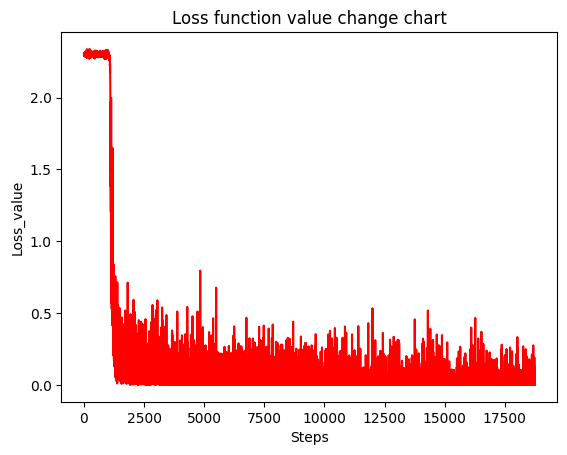

In [26]:
steps = step_loss["step"]
loss_value = step_loss["loss_value"]
steps = list(map(int, steps))
loss_value = list(map(float, loss_value))
plt.plot(steps, loss_value, color="red")
plt.xlabel("Steps")
plt.ylabel("Loss_value")
plt.title("Loss function value change chart")
plt.show()

In [27]:
def test_net(network, model, mnist_path):
    """Define the evaluation method."""
    print("============== Starting Testing ==============")
    # load the saved model for evaluation
    #param_dict = load_checkpoint("checkpoint_lenet-1_{}.ckpt".format(str(i*125)))
    param_dict = load_checkpoint("checkpoint_lenet-10_1875.ckpt")
    # load parameter to the network
    load_param_into_net(network, param_dict)
    # load testing dataset
    ds_eval = create_dataset(os.path.join(mnist_path, "test"))
    acc = model.eval(ds_eval, dataset_sink_mode=True)
    print("============== Accuracy:{} ==============".format(acc))

test_net(network, model, mnist_path)

[WARNING] ME(15604:13072,MainProcess):2023-06-02-19:25:44.238.843 [mindspore\dataset\core\validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(15604:13072,MainProcess):2023-06-02-19:25:44.239.439 [mindspore\dataset\core\validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(15604:13072,MainProcess):2023-06-02-19:25:44.240.454 [mindspore\dataset\core\validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(15604:13072,MainProcess):2023-06-02-19:25:44.241.448 [mindspore\dataset\core\validator_helpers.py:806] 'HWC

============== Starting Testing ==============
============== Accuracy:{'Accuracy': 0.9897836538461539} ==============


In [28]:
def acc_model_info(network, model, mnist_path, model_numbers, epoch_size):
    """Define the plot info method"""
    step_list = []
    acc_list = []
    for i in range(1, epoch_size+1):
        # load the saved model for evaluation
        #加载同一个模型得到的模型训练步数变化，精度随之变化
        #param_dict = load_checkpoint("checkpoint_lenet-1_1875.ckpt")
        #加载不同一个模型得到的模型训练步数变化，精度随之变化
        param_dict = load_checkpoint("checkpoint_lenet-{}_1875.ckpt".format(str(i)))
        # load parameter to the network
        load_param_into_net(network, param_dict)
        # load testing dataset
    for i in range(1, model_numbers+1):
        ds_eval = create_dataset(os.path.join(mnist_path, "test"))
        acc = model.eval(ds_eval, dataset_sink_mode=True)
        acc_list.append(acc['Accuracy'])
        step_list.append(i*125)
    return step_list,acc_list

# Draw line chart according to training steps and model accuracy
l1,l2 = acc_model_info(network, model, mnist_path, 15, 10)
plt.xlabel("Model of Steps")
plt.ylabel("Model accuracy")
plt.title("Model accuracy variation chart")
plt.plot(l1, l2, 'red')
plt.show()

ValueError: For 'load_checkpoint', the checkpoint file: D:\GitCode\MindSporeTest\checkpoint_lenet-1_1875.ckpt does not exist, please check whether the 'ckpt_file_name' is correct.

[WARNING] ME(15604:13072,MainProcess):2023-06-02-19:57:11.970.371 [mindspore\dataset\core\validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(15604:13072,MainProcess):2023-06-02-19:57:11.971.368 [mindspore\dataset\core\validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(15604:13072,MainProcess):2023-06-02-19:57:11.971.368 [mindspore\dataset\core\validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(15604:13072,MainProcess):2023-06-02-19:57:11.972.420 [mindspore\dataset\core\validator_helpers.py:806] 'HWC

All the figures in this group are predicted correctly！
[0 9 6 6 4 2 7 4 8 8 8 5 3 7 1 0 0 9 3 4 4 6 2 0 9 6 1 9 5 9 6 9] <--Predicted figures
[0 9 6 6 4 2 7 4 8 8 8 5 3 7 1 0 0 9 3 4 4 6 2 0 9 6 1 9 5 9 6 9] <--The right number


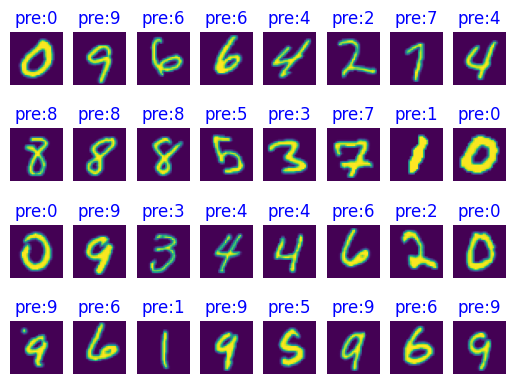

In [34]:
ds_test = create_dataset(test_data_path).create_dict_iterator()
data = ds_test.__next__()
images = data["image"].asnumpy()
labels = data["label"].asnumpy() # The subscript of data picture is the standard for us to judge whether it is correct or not

output =model.predict(Tensor(data['image']))
# The predict function returns the probability of 0-9 numbers corresponding to each picture
prb = output.asnumpy()
pred = np.argmax(output.asnumpy(), axis=1)
err_num = []
index = 1
for i in range(len(labels)):
    plt.subplot(4, 8, i+1)
    color = 'blue' if pred[i] == labels[i] else 'red'
    plt.title("pre:{}".format(pred[i]), color=color)
    plt.imshow(np.squeeze(images[i]))
    plt.axis("off")
    if color == 'red':
        index = 0
        # Print out the wrong data identified by the current group
        print("Row {}, column {} is incorrectly identified as {}, the correct value should be {}".format(int(i/8)+1, i%8+1, pred[i], labels[i]), '\n')
if index:
    print("All the figures in this group are predicted correctly！")
print(pred, "<--Predicted figures") # Print the numbers recognized by each group of pictures
print(labels, "<--The right number") # Print the subscript corresponding to each group of pictures
plt.show()

Figure 1 probability of corresponding numbers [0-9]:
 [-1.4181529  -8.584765    0.24522279 -1.714412    6.5558214  -4.1861544
 -8.743633    2.0351827  -2.7320871  17.729288  ]


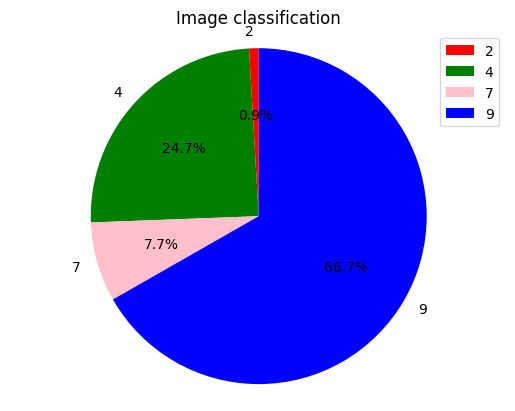

Figure 2 probability of corresponding numbers [0-9]:
 [-1.4111831e+01 -1.0683544e-02 -1.1710838e+00  2.9138346e+01
 -1.5666421e+01  8.7951517e+00 -1.0209985e+01  1.6514955e+00
  4.8934469e+00  3.7869388e-01]


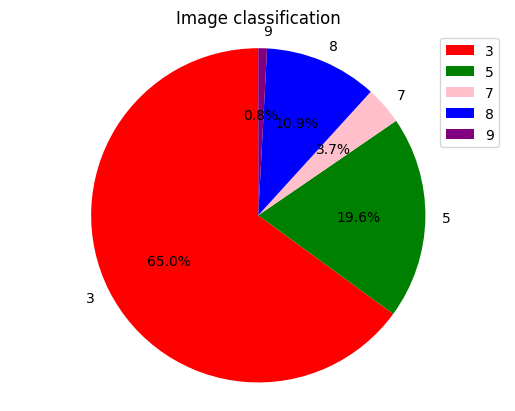

In [30]:
# define the pie drawing function of probability analysis
def plot_pie(prbs):
    dict1 = {}
    # Remove the negative number and build the dictionary dict1. The key is the number and the value is the probability value
    for i in range(10):
        if prbs[i] > 0:
            dict1[str(i)] = prbs[i]

    label_list = dict1.keys()    # Label of each part
    size = dict1.values()    # Size of each part
    colors = ["red", "green", "pink", "blue", "purple", "orange", "gray"] # Building a round cake pigment Library
    color = colors[: len(size)]# Color of each part
    plt.pie(size, colors=color, labels=label_list, labeldistance=1.1, autopct="%1.1f%%", shadow=False, startangle=90, pctdistance=0.6)
    plt.axis("equal")    # Set the scale size of x-axis and y-axis to be equal
    plt.legend()
    plt.title("Image classification")
    plt.show()
    
    
for i in range(2):
    print("Figure {} probability of corresponding numbers [0-9]:\n".format(i+1), prb[i])
    plot_pie(prb[i])